# Figure 2

After [loading the data](#Loading-the-data), we create [tranches of genes](#Gene-tranches) of different sorts, and then we create the following subfigures.

- [Clonally significant genes](#Clonally-significant-genes) (via ANOVA F and Kruskal-Wallis) and clustering with UMAP

- The [clonal proportion of variance](#Clonal-proportion-of-variance), for different tranches of genes.

- A [machine learning classifier (Linear SVM)](#SVM-classification) separates all nine clones.

- [Heatmap](#Heatmaps) showing on/off genes and heatmap with cont genes – violin plots of examples of each (maybe 5 genes/type)

- Gene Ontology analysis – I can find a Python package for this – want some way to identify the kinds of genes that are significant

- [Clonal pathway analysis](#Clonal-pathway-analysis) – Ribosomal genes, Mito genes, TCR signaling pathway, Cytotoxic genes – message being that biological circuits can exhibit clonal differences that could tune them in unpredictable ways

(For the above – maybe some sort of population level vs clonal gene vs gene correlation analysis.  To see if the population level covariance conforms to the clonal covariance patterns?  We can discuss this but it goes to the pathway analysis – is it possible that genes which show common patterns of covariance in ALL cells can be uncoupled in a given clone?  Can we measure this?)

# Loading the data

Here we load all the packages that we need, and import the data (pickled by a preprocessing notebook).

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
import statsmodels.api as sm
import scipy.stats as ss
from IPython.display import display # Pretty display of data frames.

# Import various functions for stats.
#from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
#from scipy.stats import kurtosis, skew, zscore # For detecting bimodality
import scipy.cluster.hierarchy as sch # For hierarchical clustering.

#from statsmodels.formula.api import ols

from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

# Put plots inline rather than in a pop-up.
%matplotlib inline

Here we load the pickles:  expression matrix for single cells and bulks, protein data, cell metadata, and gene metadata.

In [2]:
EM = pd.read_pickle('P1902_EM.pkl') # Load normalized expression matrix from a pickle.
EM_bulks = pd.read_pickle('P1902_EM_bulks.pkl') # Load normalized expression matrix from a pickle.
protein_df = pd.read_pickle('P1902_protein.pkl') # Load proteins from a pickle.
meta_df = pd.read_pickle('P1902_meta.pkl') # Load metadata from a pickle.
gene_df = pd.read_pickle('P1902_genes.pkl') # Load metadata from a pickle.

We extract lists of genes, cells, and bulks.  We custom-make the list of clones, to choose their order.

In [3]:
genes = list(EM.columns)  # The names of the genes. 
cells = list(EM.index) # The names of the cells.
bulks = list(EM_bulks.index) # The names of the bulks.
clones = ['H2', 'B4', 'A7', 'G6', 'A8', 'G8', 'H9', 'F3', 'E4'] 
print(clones) # Convenient reordering of clones, MEM then A7 then EFF then E4.

['H2', 'B4', 'A7', 'G6', 'A8', 'G8', 'H9', 'F3', 'E4']


Let's examine the metadata.

In [4]:
meta_df[:5]

Condition  Cell_Number Clone_ID  Day  In_Vivo_Clone_ID Project_ID
P1902_1289  In_Vitro          1.0       E4  NaN               NaN      P1902
P1902_1290  In_Vitro          1.0       E4  NaN               NaN      P1902
P1902_1291  In_Vitro          1.0       E4  NaN               NaN      P1902
P1902_1292  In_Vitro          1.0       E4  NaN               NaN      P1902
P1902_1293  In_Vitro          1.0       A7  NaN               NaN      P1902

We place this data into new dataframes called X and y, to follow the machine-learning tradition.  X is the feature matrix (gene expressions of each cell) and y has the classes (clonality of each cell).  For permutation tests, we also create a shuffled version of y, with shuffled clone-labels.

In [5]:
X = EM.copy()  # The features.  Copied in memory, just in case.
y = meta_df.Clone_ID.loc[cells] # We are trying to predict clonality from the features.
yshuff = pd.Series(np.random.permutation(y.values), index=y.index, name='Clone_ID')

# Gene tranches

In this section, we make tranches of genes based on different properties.  For each tranche, we create a pandas series or dataframe named `XXX_df` with all genes and score(s) reflecting the property.  The dataframe is ordered from most to least, and we pick out the top 100 for a tranche called `genes_XXX`.

## Most variable genes, by "Distance to Median"

Here we assess the variability of genes, as compared to genes with similar mean expression level.  This is based on the "distance-to-median" measure DM described in [Newman, J., Ghaemmaghami, S., Ihmels, J. et al. *Single-cell proteomic analysis of S. cerevisiae reveals the architecture of biological noise*. Nature 441, 840–846 (2006).](https://doi.org/10.1038/nature04785).  

We begin by computing the DM (measure of variability) for all expressed genes.

In [6]:
def make_DM(gf, threshold = 10, window = 100):
    EM_un = np.exp(gf) - 1.0 # Undo the log(x+1) normalization.
    EM_mean = EM_un.mean()
    EM_mean = EM_mean[EM_mean > threshold].sort_values() 
    genes_high = EM_mean.index
    EM_un = EM_un[genes_high]
    EM_CVs = (EM_un.std() / (EM_mean+1.0))**2 # squared coefficient of variation. Added 1.0 to avoid div-by-zero.
    EM_logCVs = np.log10(EM_CVs+1.0) # Log base 10
    EM_roll = EM_logCVs.rolling(window).median()
    EM_roll[:window-1] = [EM_roll[window-1]] * (window-1) # Fill in missing values from rolling average.
    return (EM_logCVs - EM_roll).sort_values(ascending=False)

In [7]:
DM_df = make_DM(EM)
DM_df.head()

Geneid
CSF2        1.053590
CCL23       0.999853
IFNG        0.931311
HIST1H4C    0.675983
CCNB1       0.655874
dtype: float64

In [8]:
genes_DM = list(DM_df[:100].index)
print(genes_DM)

['CSF2', 'CCL23', 'IFNG', 'HIST1H4C', 'CCNB1', 'RRM2', 'FGFBP2', 'ALKBH3', 'NAT9', 'GNG8', 'VTRNA1-3', 'UBA52P5', 'AL031320.1', 'ZBTB17', 'PDCD11', 'BTD', 'TK1', 'CCL4L1!1', 'AC084018.1', 'GEM', 'SNORD99', 'LRRC28', 'RAD51', 'STMN1', 'UBE2C', 'RP13-297E16.4', 'ARRB1', 'SNORA77!2', 'SNORA25!13', 'TOP2A', 'SOX4', 'SNORA12!2', 'SRM', 'CDR2', 'GZMK', 'ABHD4', 'NMRAL1', 'NR4A2', 'EGR1', 'FEZ1', 'ZNF45', 'CDKN3', 'EIF2D!0', 'GALE', 'TROAP', 'KLRG1', 'CCDC101', 'TMEM173', 'C11orf24', 'PABPC1L', 'GZMH', 'KIR2DL4!0', 'RGCC', 'RP11-23J18.1', 'MIR103A2', 'ATG7', 'TMEM187!1', 'HRSP12', 'ERMARD', 'IFT52', 'PVT1', 'SNHG1', 'NCAPH2', 'NUSAP1', 'PTCHD3P1', 'TMEM71', 'PNKP', 'RP11-571M6.8', 'PAK1', 'PMCH', 'MCM7', 'RAD51B', 'ADIPOR2', 'ALDOC', 'CXCR4', 'POR!0', 'RASD1', 'GRN', 'CDKN1A', 'PLCG2', 'BTN3A3', 'GGH', 'CDK5', 'SFXN4', 'CCNB2', 'CAPG', 'JOSD1', 'CYB5D2', 'QARS', 'NISCH', 'ALAD', 'MPZL2', 'TNFRSF9', 'ARRDC1', 'FOCAD', 'TTC27', 'LAIR2!1', 'AC027763.2', 'B9D2', 'FBXL12']


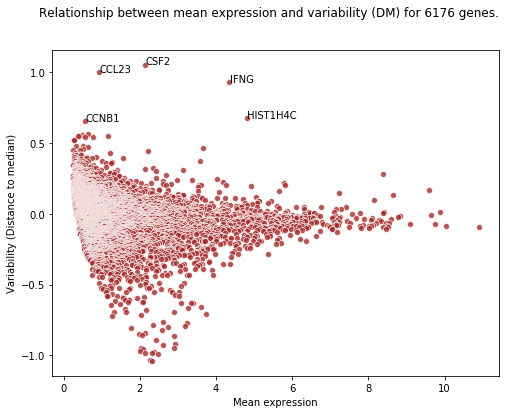

In [9]:
plot_df = pd.DataFrame(index = DM_df.index)
plot_df['Variability (Distance to median)'] = DM_df
plot_df['Mean expression'] = EM[DM_df.index].mean()

fig,ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x = 'Mean expression', y = 'Variability (Distance to median)', data=plot_df, 
               color='brown', alpha=0.8)

def label_point(x, y, ax):
    a = pd.concat({'x': x, 'y': y}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], i)

genes_label = list(DM_df[DM_df > 0.6].index)
label_point(plot_df['Mean expression'][genes_label], plot_df['Variability (Distance to median)'][genes_label], plt.gca())

plt.suptitle('Relationship between mean expression and variability (DM) for {} genes.'.format(len(plot_df)))

plt.show()

## Always on genes

Some genes are "always on" -- almost every cell expressed the gene above some minimum threshold.  We pick these out here.

In [10]:
def make_ON(gf, threshold = 10):
    log_threshold = np.log1p(threshold)
    N = len(gf)
    return ((gf > log_threshold).sum() / N).sort_values(ascending=False)

In [11]:
ON_df = make_ON(EM)
ON_df.head()

Geneid
MT-ND4L    1.0
RPL7       1.0
PFN1       1.0
RPS26      1.0
MYL6       1.0
dtype: float64

In [12]:
genes_ON = list(ON_df[:100].index)
print('The following genes are expressed by over {:.1%} cells:  {}'.format(
    ON_df[100], ', '.join(genes_ON)))

The following genes are expressed by over 95.1% cells:  MT-ND4L, RPL7, PFN1, RPS26, MYL6, B2M, SERF2, TMSB4X, SRP14, CCL5!1, SH3BGRL3, MT-RNR2, MALAT1, APOBEC3C, MT-CO1, ARPC2, MT-CO2, H3F3B, MTATP6P1, IL32, ACTB, MT-CYB, RPS27, MT-CO3, MT-ATP6, AC010970.2, MT-ND4, RPS19!0, MYL12A, HNRNPH1, CAPZA1, CD3D, UBB, EIF5A, GZMB, FTL, TMSB4XP1, TRAC, MT-ATP8, MT-TE, TMSB4XP8, ARHGDIB, RPLP1, MT-RNR1, RPL41, CD3G, TMSB10, STK17B, GNLY, AC092580.4, CD2, SET, NKG7, IL2RG, MT-ND5, SRGN, LTB!1, RPL36AL, MT-TY, CFL1, ID2, PPP1CB, RPS14, C6orf62, PTPRC!1, MT-TP, TMBIM6, HLA-A!1, CALM1, RPL31, HLA-B!1, CLIC1!6, GMFG, YWHAZ, RPL21, CCL4, RPS29, IFI6, RPL18A, CALM2, CD74, FTH1, S100A6, RPL23A, MT-ND2, ATP5L!1, CD52, CLEC2D, ATP5E, DAZAP2, HLA-C!1, CD3E, HMGB1, CST7, EEF1A1, HCST, SEC22B!0, ARL6IP5, C16orf54, CDC42SE2


## Clonally significant genes

Here we carry out a one-way ANOVA to assign each gene an F-statistic and associated p-value.  We carry this out "from scratch" since we will use the interclonal and intraclonal components of variance later.  The following function carries out the ANOVA and outputs a dataframe.

In [13]:
#def make_F_table(p_list, num_groups, num_samples):
#    return ss.f.isf(p_list, num_groups - 1, num_samples - num_groups)

In [14]:
def ANOVA(gf, grouper):
    N = len(gf)
    grand_mean = gf.mean()
    

    SS_total = (gf - grand_mean)**2 # Total variability as SS.
    SS_total = SS_total.sum() # Total sum of squares.
    
    group_N = grouper.loc[gf.index].value_counts() # Clonal populations.
    num_groups = len(group_N) # Number of clones
    group_means = gf.groupby(grouper).mean() # Means within each clone.
    
    intragroup_SS = gf.groupby(grouper).var() # Use speedy variance function in pandas.
    intragroup_SS = intragroup_SS.apply(lambda col : col * (group_N - 1))
    intragroup_SS = intragroup_SS.sum()
    
    intergroup_SS = (group_means - grand_mean)**2
    intergroup_SS = intergroup_SS.apply(lambda col : col * group_N)
    intergroup_SS = intergroup_SS.sum()
    
    df = pd.DataFrame(index = SS_total.index)
    df['total variance'] = SS_total
    df['interclonal variance'] = intergroup_SS
    df['intraclonal variance'] = intragroup_SS
    df['ANOVA F'] = df['interclonal variance'] / df['intraclonal variance']
    df['ANOVA F'] = df['ANOVA F'] * (N - num_groups) / (num_groups - 1)
    df['p'] = df['ANOVA F'].apply(lambda Fstat : ss.f.sf(Fstat, num_groups - 1, N - num_groups))
    
    return df.sort_values('p')

Carrying out the ANOVA on all 7000+ genes will take a minute or so.

In [15]:
ANOVA_df = ANOVA(EM, meta_df['Clone_ID'])
ANOVA_df.head()

total variance  interclonal variance  intraclonal variance  \
Geneid                                                                   
LRRC28         3736.732788           2185.231535           1551.501252   
PLS3!0         1394.746627            778.917881            615.828747   
REG4           1572.169819            840.506656            731.663163   
AMICA1         3726.014234           1976.564203           1749.450031   
AC010970.2      110.085410             54.635851             55.449559   

              ANOVA F             p  
Geneid                               
LRRC28      59.155430  1.222859e-59  
PLS3!0      53.122806  3.268419e-55  
REG4        48.247994  1.978813e-51  
AMICA1      47.452454  8.558586e-51  
AC010970.2  41.383660  9.387533e-46

We also carry out the same ANOVA on the data with shuffled clone-labels for later comparison.

In [16]:
ANOVA_df_shuff = ANOVA(EM, yshuff)
ANOVA_df_shuff.head()

total variance  interclonal variance  intraclonal variance  \
Geneid                                                                      
CEP85L             727.138335             60.001918            667.136417   
RP11-252A24.7     1996.137545            152.926826           1843.210719   
SCO2               919.715421             70.257317            849.458104   
ALKBH3             750.566428             56.747958            693.818470   
MED17              696.795186             51.590410            645.204777   

                ANOVA F         p  
Geneid                             
CEP85L         3.777459  0.000293  
RP11-252A24.7  3.484640  0.000702  
SCO2           3.473753  0.000725  
ALKBH3         3.435213  0.000813  
MED17          3.358309  0.001020

Now we compute the nonparametric analogue of the ANOVA F: the Kruskal-Wallis H statistic.

In [17]:
def KruskalWallis(gf, grouper):
    N = len(gf) # Number of cells
    gf_rank = gf.rank() # Turn gene expressions into ranks, 1...N.
    
    group_N = grouper.loc[gf.index].value_counts() # Clonal populations
    num_groups = len(group_N) # Number of clones.
    
    meanrank = (1+N)/2 # Mean of all the ranks. 
    ties = gf_rank.apply(lambda col : ss.tiecorrect(col)) # Tie correction for Kruskal-Wallis.
    
    gf_rankmean = gf_rank.groupby(grouper).mean() # Compute mean ranks, the \bar r_i.
    scaling = 12 / (ties * N*(N+1))
    
    KW_frame = (gf_rankmean - meanrank).mul(np.sqrt(group_N), axis=0)
    KW_frame = KW_frame * np.sqrt(scaling)
    H = (KW_frame**2).sum(axis=0)
    
    df = pd.DataFrame(index = gf.columns)
    df['Kruskal-Wallis H'] = H 
    df['p'] = ss.distributions.chi2.sf(H, num_groups - 1)
    return df

We compute this for the real clones, and then for the shuffled clone labels.

In [18]:
KW_df = KruskalWallis(EM, meta_df['Clone_ID'])
KW_df.sort_values('p')

Kruskal-Wallis H             p
Geneid                                     
REG4               225.268910  2.964544e-44
LRRC28             208.027113  1.297747e-40
AMICA1             190.053906  7.933944e-37
PLS3!0             184.450695  1.195755e-35
AC010970.2         176.468539  5.674821e-34
...                       ...           ...
TMEM230              1.186554  9.967730e-01
AFG3L1P              1.069175  9.977724e-01
SEC23IP              1.007761  9.981989e-01
RPL23AP82!1          0.977202  9.983884e-01
GCDH                 0.608771  9.997193e-01

[7433 rows x 2 columns]

In [19]:
KW_df_shuff = KruskalWallis(EM, yshuff)
KW_df_shuff.sort_values('p')

Kruskal-Wallis H         p
Geneid                                   
MED13L                31.262182  0.000126
PSAP                  26.726148  0.000788
RP11-252A24.7         26.088264  0.001014
NDUFV2                25.983872  0.001057
RMND5A                25.850588  0.001114
...                         ...       ...
NR4A2                  0.798228  0.999230
EIF3D                  0.660980  0.999618
ELAVL1                 0.653906  0.999633
EFR3A                  0.551580  0.999806
TIFA                   0.519366  0.999846

[7433 rows x 2 columns]

## Clonally significant on/off genes

In [20]:
selector = make_pipeline(Binarizer(threshold=1.0), 
                        SelectKBest(score_func = chi2, k='all'))

selector.fit(X,y)
skb = selector.named_steps['selectkbest']
selected_genes = list(compress(genes, skb.get_support()))

onoff_df = pd.DataFrame(index=selected_genes, columns=['chi2', 'p_value'])
onoff_df.chi2 = list(compress(skb.scores_, skb.get_support()))
onoff_df.p_value = list(compress(skb.pvalues_, skb.get_support()))
onoff_df.sort_values('p_value', inplace = True)
genes_onoff = list(onoff_df[:100].index)

In [21]:
onoff_df.head()

chi2       p_value
PLS3!0  161.147049  9.205697e-31
REG4    150.594897  1.473459e-28
LRRC28  118.906482  5.575109e-22
GPR15   103.807020  7.101751e-19
TIMD4   101.885614  1.756846e-18

## Genes in pathways

In [23]:
curated_genetable = pd.read_csv('Pathway_List_Feb182020_JEMcurated.csv', sep=',')
pathways = list(curated_genetable.columns)
print ('{} pathways found: {}'.format(len(pathways), ', '.join(pathways)))

8 pathways found: CD3/TCR Signaling, Cytotoxicity, Exhaustion, IL-2R Signaling, Ribosomal Processes, MT-genes, Mitochondrial Respiration, Interferon Signaling


In [24]:
gene_labels = pd.Series(index=genes)
for pathway in pathways:
    for gene in curated_genetable[pathway]:
        if type(gene) == str:
            gene_list = [g for g in genes if g == gene or g.startswith(gene+'!')]
            for gene in gene_list:
                gene_labels[gene] = pathway

In [25]:
gene_paths = {pathway : sorted(list(gene_labels[gene_labels == pathway].index)) for pathway in pathways}
for pathway in pathways:
    print('Pathway {} contains the following genes:  {}.'.format(pathway, ', '.join(gene_paths[pathway])))
    print('---------------------------------------')

Pathway CD3/TCR Signaling contains the following genes:  CD247, CD3D, CD3E, CD3G, CD8A, CD8B, FYN, LAT, LCK, LCP2, MAPK1, MAPK14, NCK1, PRKCQ, ZAP70.
---------------------------------------
Pathway Cytotoxicity contains the following genes:  CD63, CTSC, CTSD, CTSL, GNLY, GZMA, GZMB, GZMH, LAMP1, LAMP2, M6PR, PRF1, RAB27A, SH2D1A, STXBP2, STXBP3, UNC13D.
---------------------------------------
Pathway Exhaustion contains the following genes:  CD244, CD28, CTLA4, HAVCR2, LAG3, MAF, PDCD1, PPP2CA, PTPN11, PTPN6!0, TIGIT, TIMD4, TNFRSF9.
---------------------------------------
Pathway IL-2R Signaling contains the following genes:  IL2RA, IL2RB, IL2RG, JAK3, PIK3CA, STAT3, STAT5B.
---------------------------------------
Pathway Ribosomal Processes contains the following genes:  RPL10!0, RPL10A, RPL11, RPL12, RPL13, RPL13A, RPL13AP5, RPL14, RPL15, RPL17, RPL18, RPL18A, RPL19, RPL21, RPL22, RPL22L1, RPL23, RPL23A, RPL23AP7, RPL23AP82!1, RPL24, RPL26, RPL26L1, RPL27, RPL27A, RPL28, RPL29, RPL3

# Clonally significant genes

We have previously computed ANOVA F and Kruskal-Wallis H-statistics for our genes, based on our clonal groups and a shuffled version for comparison.  In this first figure, we use this to count and identify the differentially expressed genes.

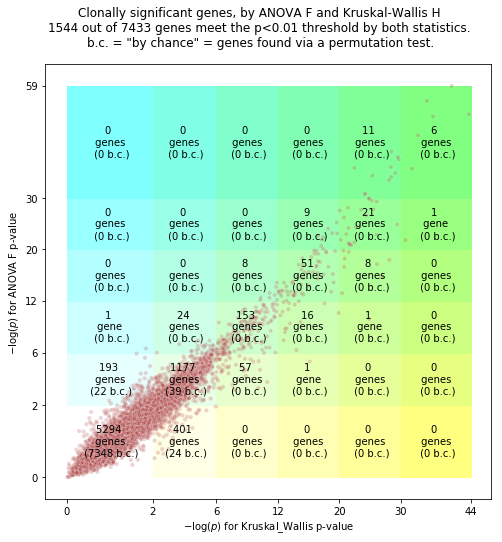

In [26]:
fig,ax = plt.subplots(figsize=(8,8))

H_logp = -np.log10(KW_df['p'])
F_logp = -np.log10(ANOVA_df['p'])

H_logp_shuff = -np.log10(KW_df_shuff['p'])
F_logp_shuff = -np.log10(ANOVA_df_shuff['p'])

H_allmax = H_logp.max()
F_allmax = F_logp.max()

#plt.xlim([0, np.sqrt(H_allmax+1)])
#plt.ylim([0, F_allmax+1])
Hcuts = [0,2,6,12,20,30,int(np.ceil(H_allmax))]
Fcuts = [0,2,6,12,20,30,int(np.ceil(F_allmax))]

sqrtHcuts = [np.sqrt(x) for x in Hcuts]
sqrtFcuts = [np.sqrt(y) for y in Fcuts]

ax.set_xticks(sqrtHcuts)
ax.set_xticklabels(Hcuts)

ax.set_yticks(sqrtFcuts)
ax.set_yticklabels(Fcuts)

for i in range(len(Fcuts) - 1):
    for j in range(len(Hcuts) - 1):
        Fmin, Fmax = sqrtFcuts[i], sqrtFcuts[i+1]
        Hmin, Hmax = sqrtHcuts[j], sqrtHcuts[j+1]
        color = (1-i*0.1,1,1-j*0.1)
        gene_FH = [gene for gene in genes if H_logp[gene] >= Hcuts[j] and H_logp[gene] < Hcuts[j+1] and
                  F_logp[gene] >= Fcuts[i] and F_logp[gene] < Fcuts[i+1]]
        
        gene_FH_shuff = [gene for gene in genes if H_logp_shuff[gene] >= Hcuts[j] and H_logp_shuff[gene] < Hcuts[j+1] and
                  F_logp_shuff[gene] >= Fcuts[i] and F_logp_shuff[gene] < Fcuts[i+1]]
        
        left, width = Hmin, Hmax-Hmin
        bottom, height = Fmin, Fmax-Fmin
        right = left + width
        top = bottom + height
        ax.add_patch(plt.Rectangle((left,bottom), width, height, zorder=-2, color=color))
        #ax = plt.gca()
        #p = plt.Rectangle((left, bottom), width, height, fill=True, color='blue')
        #p.set_transform(ax.transAxes)
        #p.set_clip_on(False)
        #ax.add_patch(p)
        offset = 0
        if len(gene_FH) == 1:
            plural = ''
        else:
            plural = 's'
        ax.text(0.5 * (left + right), 0.5 * (bottom + top) - offset, '{} \n gene{} \n ({} b.c.)'.format(
            len(gene_FH),plural, len(gene_FH_shuff)),
            horizontalalignment='center',
            verticalalignment='center', color = 'k')

sns.scatterplot(np.sqrt(H_logp), np.sqrt(F_logp), ax=ax, color='brown', size=0.5, 
                edgecolor = 'white', alpha=0.2, legend=None) #color=(1,0.9,0.9))
ax.set_xlabel('$-\log(p)$ for Kruskal_Wallis p-value')
ax.set_ylabel('$-\log(p)$ for ANOVA F p-value')

sig_genes = [gene for gene in genes if H_logp[gene] > 2 and F_logp[gene] > 2]

plt.suptitle('Clonally significant genes, by ANOVA F and Kruskal-Wallis H \n'
             '{} out of {} genes meet the p<0.01 threshold by both statistics. \n'
             'b.c. = "by chance" = genes found via a permutation test.'.format(len(sig_genes), len(genes)))
plt.show()

In [27]:
genes_sig2 = [gene for gene in genes if (H_logp[gene] > 2) and (F_logp[gene] > 2)]
print('{} genes meet the p<0.01 threshold for both F and H statistics'.format(len(genes_sig2)))

genes_sig2_shuff = [gene for gene in genes if (H_logp_shuff[gene] > 2) and (F_logp_shuff[gene] > 2)]
print('{} genes found by chance'.format(len(genes_sig2_shuff)))

1544 genes meet the p<0.01 threshold for both F and H statistics
39 genes found by chance


In [28]:
genes_sig6 = [gene for gene in genes if (H_logp[gene] > 6) and (F_logp[gene] > 6)]
print('{} genes meet the p < 1e-6 threshold for both F and H statistics'.format(len(genes_sig6)))

genes_sig6_shuff = [gene for gene in genes if (H_logp_shuff[gene] > 6) and (F_logp_shuff[gene] > 6)]
print('{} genes found by chance'.format(len(genes_sig6_shuff)))

285 genes meet the p < 1e-6 threshold for both F and H statistics
0 genes found by chance


In [29]:
genes_sig12 = [gene for gene in genes if (H_logp[gene] > 12) and (F_logp[gene] > 12)]
print('{} genes meet the p<1e-12 threshold for both F and H statistics'.format(len(genes_sig12)))

genes_sig12_shuff = [gene for gene in genes if (H_logp_shuff[gene] > 12) and (F_logp_shuff[gene] > 12)]
print('{} genes found by chance'.format(len(genes_sig12_shuff)))

107 genes meet the p<1e-12 threshold for both F and H statistics
0 genes found by chance


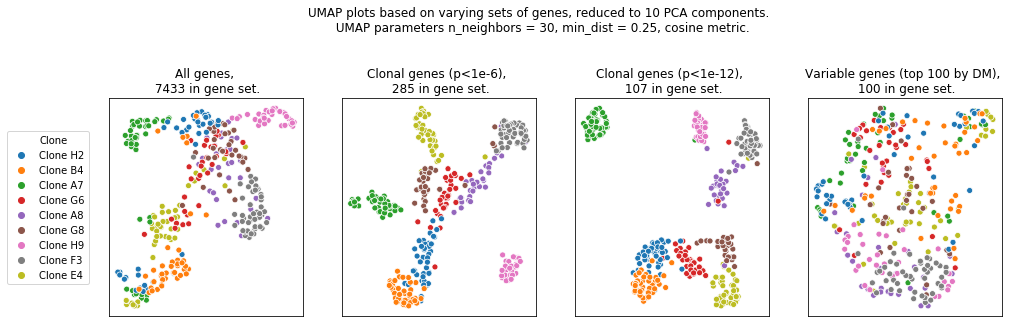

In [30]:
tranches = {'All genes': genes,
           'Clonal genes (p<1e-6)' : genes_sig6,
           'Clonal genes (p<1e-12)' : genes_sig12,
           'Variable genes (top 100 by DM)' : genes_DM}

no_cuts = len(tranches)

n_components = 10
n_neighbors = 30
min_dist = 0.25

fig, ax = plt.subplots(1,no_cuts,figsize=(4*no_cuts,4))
j = 0
for tranch in tranches:
    genelist = tranches[tranch]
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X[genelist]) # Apply PCA with 10 components.
    X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

    cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
    cl_df['Clone'] = 'Clone ' + y
    hue_order = ['Clone ' + clone for clone in clones]

    #sns.set(rc={'figure.figsize':(7,7)})
    if j > 0:
        sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', hue_order = hue_order, data = cl_df, legend = None, ax=ax[j])
    else:
        g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', hue_order = hue_order, data = cl_df, ax=ax[j])
        g.legend(loc='center left', bbox_to_anchor=(-0.55, 0.5), ncol=1)
    
    ax[j].set_title("{}, \n {} in gene set.".format(tranch, len(genelist)))
    #if j > 0:
    #    ax[j].yaxis.label.set_visible(False)
    ax[j].get_xaxis().set_visible(False) 
    ax[j].get_yaxis().set_visible(False)
    j += 1
    
plt.suptitle("UMAP plots based on varying sets of genes, reduced to {} PCA components. \n "
             "UMAP parameters n_neighbors = {}, min_dist = {}, cosine metric.".format(n_components,
                                                                                      n_neighbors, min_dist), 
            y=1.2)
    
plt.show()

Clones B4 and H2 seem hardest to separate.  They are both MEM-type clones, so their gene expression profiles may naturally be closer to each other.  Note that using just the most variable genes (by DM) is *not* a very good way of finding the clones!

# Clonal proportion of variance

Let's take another look at our ANOVA dataframe.

In [31]:
ANOVA_df.head()

total variance  interclonal variance  intraclonal variance  \
Geneid                                                                   
LRRC28         3736.732788           2185.231535           1551.501252   
PLS3!0         1394.746627            778.917881            615.828747   
REG4           1572.169819            840.506656            731.663163   
AMICA1         3726.014234           1976.564203           1749.450031   
AC010970.2      110.085410             54.635851             55.449559   

              ANOVA F             p  
Geneid                               
LRRC28      59.155430  1.222859e-59  
PLS3!0      53.122806  3.268419e-55  
REG4        48.247994  1.978813e-51  
AMICA1      47.452454  8.558586e-51  
AC010970.2  41.383660  9.387533e-46

For each gene, we can compute its $\eta^2$ statistic, which is the ratio (interclonal variance) / (total variance).  For any *set* of genes, we compute something analogous:  the (total interclonal variance) / (total total variance).  The following function computes this gene-set $\eta^2$ statistic, using the real clone labels by default, and our shuffled clone labels for comparison (by setting `shuff` to `True`). 

In [32]:
def clonal_proportion(genelist, shuff=False):
    if shuff:
        sums = ANOVA_df_shuff.loc[genelist].sum()
    else:
        sums = ANOVA_df.loc[genelist].sum()
    return sums['interclonal variance'] / sums['total variance']

We plot the clonal proportion of variance for some of our gene tranches.  We compare to the chance outcomes (shuffled clone labels) as well.

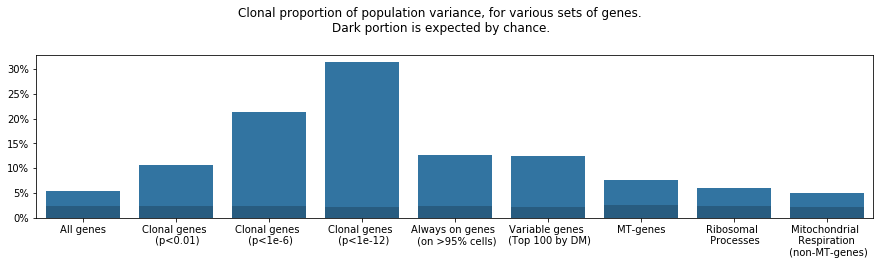

In [33]:
tranches = {'All genes' : genes,
           'Clonal genes \n (p<0.01)' : genes_sig2,
           'Clonal genes \n (p<1e-6)' : genes_sig6,
           'Clonal genes \n (p<1e-12)' : genes_sig12,
           'Always on genes \n (on >95% cells)' : genes_ON,
           'Variable genes \n (Top 100 by DM)' : genes_DM,
           'MT-genes' : gene_paths['MT-genes'],
           'Ribosomal \n Processes' : gene_paths['Ribosomal Processes'],
           'Mitochondrial \n Respiration \n (non-MT-genes)' : gene_paths['Mitochondrial Respiration']}

x_list = list(tranches.keys())
y_list = [clonal_proportion(tranches[tranch]) for tranch in tranches.keys()]
y_list_shuff = [clonal_proportion(tranches[tranch], shuff=True) for tranch in tranches.keys()]

fig,ax = plt.subplots(figsize = (15,3))

sns.barplot(x=x_list, y=y_list, color = 'tab:blue')
sns.barplot(x=x_list, y=y_list_shuff, color='black', alpha=0.2)

plt.suptitle('Clonal proportion of population variance, for various sets of genes. \n'
             'Dark portion is expected by chance.', y=1.1)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.show()

# SVM classification

The clustering makes it clear that differentially expressed genes can be used to separate clones.  A priori, this might be a case of overfitting -- with 7000+ genes and 9 clusters, perhaps it is not surprising that clonal information can be used to choose genes, which then can be used to separate clones.

In this section, we follow the typical supervised machine learning workflow -- dividing the data into training and testing sets, and using the gene expression profiles of training cells (with clonality) to train a classifier to predict clonality of testing cells.  We use a linear SVM classifier below.  We also tried Bernoulli and Gaussian naive Bayesian classifiers, but SVM worked best (with Bernoulli naive Bayes a close second).

## Visualization functions

We create some general-purpose functions for visualization below.

In [34]:
def CV_map(gs, swap=False, savefig=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))
    if savefig:
        plt.savefig('CV_map.svg')

In [35]:
from sklearn import base

def confusion_matrix(X,y,pipe, reps=2, classlist = None):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    
    f, ax = plt.subplots(figsize=(8,7))
    sns.heatmap(valid, annot=valid, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.046, 'pad':0.04}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .5, .75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_ylabel("Actual class")
    ax.set_xlabel("Predicted class")
    ax.set_title("Overall prediction accuracy {:0.3%}. \n"
                 "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

In [36]:
def sort_by(df, col, valuelist):
    '''
    Sorts a data frame, according to the values in a column,
    and a chosen order for these values.
    '''
    if set(df[col].unique()) != set(valuelist):
        print('Warning, cannot sort!')
        return df
    value_dict = {valuelist[j]:j for j in range(len(valuelist))}
    df['newcol'] = df[col].apply(lambda v : value_dict[v])
    df.sort_values('newcol', inplace=True)
    df.drop('newcol', axis=1)
    return df

In [37]:
#  DANGER DANGER!  The lines below ignore all warnings.
#  It's nice to avoid all the convergence warnings.  
#  But dangerous in general.
import warnings
warnings.filterwarnings("ignore")
#  End of warning.... proceed below.

SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=1.0, max_iter=2000)) ])

param_grid = dict(skb__k = [2,5,10,20,30,50,75,100,125,150,200,250,300], svm__C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('mm',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('skb',
                                        SelectKBest(k=110,
                                                    score_func=<function f_classif at 0x1c1b874680>)),
                                       ('svm',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=2000,
                                                  multi_class='ovr',
                          

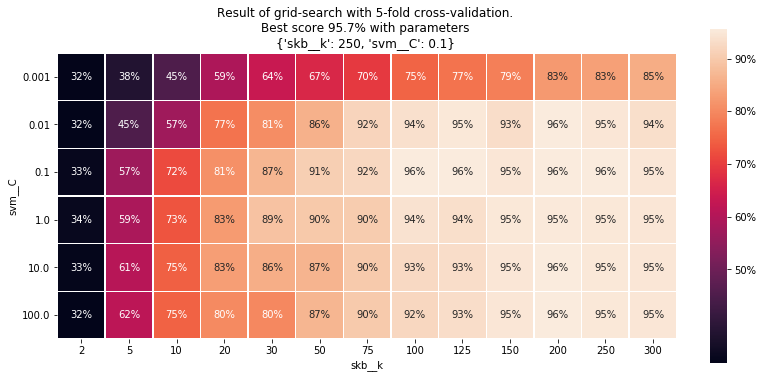

In [38]:
CV_map(grid_search, swap=True)

In [39]:
k_testlist = list(range(1,10)) + list(range(10,20,2)) + list(range(20,40,5)) + list(range(40,90,10)) + list(range(100,200,25)) + list(range(200,400,50)) + list(range(400,801,100))
SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=0.1, max_iter=2000)) ])

param_grid = dict(skb__k = k_testlist, svm__C = [0.1])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('mm',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('skb',
                                        SelectKBest(k=110,
                                                    score_func=<function f_classif at 0x1c1b874680>)),
                                       ('svm',
                                        LinearSVC(C=0.1, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=2000,
                                                  multi_class='ovr',
                          

In [40]:
SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=0.1, max_iter=2000)) ])

param_grid = dict(skb__k = k_testlist, svm__C = [0.1])

grid_search_shuff = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search_shuff.fit(X,yshuff)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('mm',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('skb',
                                        SelectKBest(k=110,
                                                    score_func=<function f_classif at 0x1c1b874680>)),
                                       ('svm',
                                        LinearSVC(C=0.1, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=2000,
                                                  multi_class='ovr',
                          

In [41]:
CV_df = pd.DataFrame()
for split in range(5):
    split_string = 'split'+str(split)+'_test_score'
    CV_df[split] = grid_search.cv_results_[split_string]
CV_df['Number of genes'] = grid_search.cv_results_['param_skb__k'].data
CV_df['Clonal prediction accuracy'] = grid_search.cv_results_['mean_test_score']

CV_df.head()
CV_melt = pd.melt(CV_df, id_vars='Number of genes', value_vars=[0,1,2,3,4], value_name='Clonal prediction accuracy')
CV_shuff = pd.DataFrame()
CV_shuff['Number of genes'] = grid_search_shuff.cv_results_['param_skb__k'].data
CV_shuff['Clonal prediction accuracy'] = grid_search_shuff.cv_results_['mean_test_score']

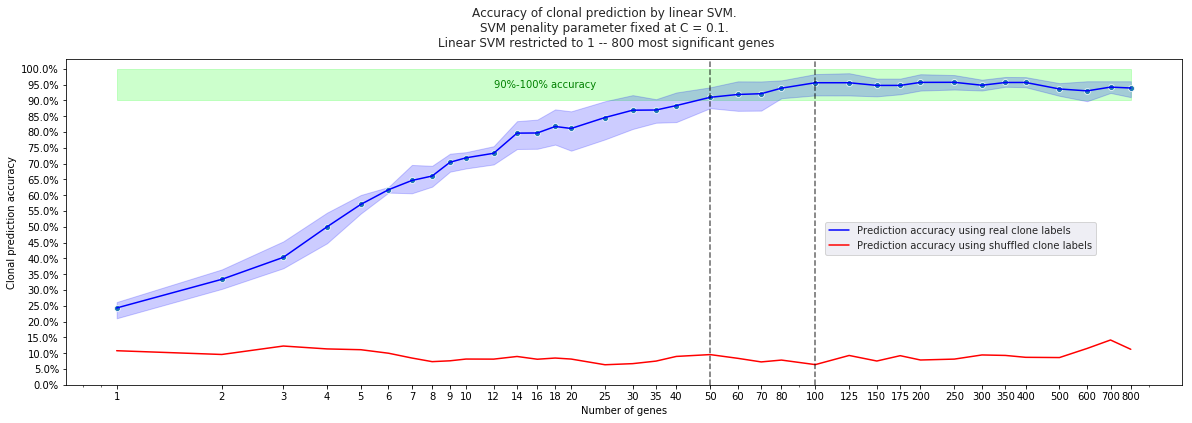

In [42]:
fig,ax = plt.subplots(figsize = (20,6))
sns.set_style("darkgrid")
sns.lineplot(x = 'Number of genes', y = 'Clonal prediction accuracy', data=CV_melt,
            color='blue', label='Prediction accuracy using real clone labels')

sns.scatterplot(x = 'Number of genes', y = 'Clonal prediction accuracy', data=CV_df)

sns.lineplot(x = 'Number of genes', y = 'Clonal prediction accuracy', data=CV_shuff, 
             color='red', label='Prediction accuracy using shuffled clone labels')

ax.set_xscale('log')
ax.set_yticks(np.linspace(0.0,1.0,21))

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(y) for y in vals])

ax.set_xticks(list(grid_search.cv_results_['param_skb__k'].data))
vals = ax.get_xticks()
ax.set_xticklabels(['{}'.format(x) for x in vals])

ax.add_patch(plt.Rectangle((1,0.9), 800, 0.1, zorder=-2, color=(0.5,1,0.5,0.4)))
ax.text(12, 0.94, '90%-100% accuracy', color='green')

ax.axvline(50, linestyle='--', color='k', alpha=0.6) # vertical lines
ax.axvline(100, linestyle='--', color='k', alpha=0.6) # vertical lines

plt.legend(bbox_to_anchor=(0.68, 0.5), loc=2, borderaxespad=0.)

plt.suptitle('Accuracy of clonal prediction by linear SVM. \n'
             'SVM penality parameter fixed at C = 0.1. \n'
            'Linear SVM restricted to {} -- {} most significant genes'.format(vals[0], vals[-1]), y=1.0)
plt.show()

# Heatmaps

In [43]:
def vis_genebars(ef, mf, genelist, prop, classlist = None, style='z_score', 
                 cutoff = 1.0, genelabels = True, samplelabels=False, 
                 fitlabels = False, gene_cluster=True, sort_samples = True,
                 gene_names = None, savefig = False):
    '''
    Visualizes gene expression across cells.
    
    Args:
        ef (pandas dataframe):  The gene expression matrix.
        mf (pandas dataframe:  The metadata dataframe.
        genelist (list): The list of genes to visualize.
        prop:  A column of the metadata, e.g. Clone_ID.  Place cells in blocks according to this.
        classlist:  Custom sort Clone_ID (or whatever prop) according to this list.
        z_score:  Plot z-scores for each gene.
        binarize:  Plot binarized data, e.g. whether a gene is on or off.
        cutoff:  The cutoff for binarization.
        genelabels:  Label the rows by genes if True.
        fitlabels:  If True, extend the height of the image to fit in all the gene labels.
        
    Returns:
        None.  Just makes a pretty picture.
        
    
    '''
    genelist = [gene for gene in genelist if gene in ef.columns]
    df = ef[genelist].copy()
    genelist = [gene.split('!')[0] for gene in genelist]
    df.columns = genelist
    df[prop] = mf[prop]
    if sort_samples:
        if classlist is None:
            df.sort_values(prop, inplace=True)
        else:
            df = sort_by(df, prop, classlist)
    
    cells = df.index
    md = mf.loc[cells]
    classes = md[prop].unique()

    # Create plot.
    
    # Adjust height to include labels.
    if fitlabels:
        figheight = len(genelist) // 4
    else:
        figheight = 12
    figsize=(12, figheight)
    
    # Create colors for clones (or whatever classes)
    pal = sns.cubehelix_palette(len(classes),light=.9, dark=.1, reverse=True, start=1, rot=-2)
    lut = dict(zip(classes, pal))
    colors = pd.Series(df[prop]).map(lut)
    
    #genepal = sns.cubehelix_palette(len(pathways),light=.9, dark=.1, reverse=True, start=1, rot=-2)
    #genelut = dict(zip(pathways, genepal))
    #genecolors = gene_labels[genelist].map(genelut)
    
    title = []
    title.append('Expression for {} genes.'.format(len(genelist)))
    
    if style == 'z_score':
        method,metric = 'average', 'cosine'
        cg = sns.clustermap(df[genelist].transpose(), z_score=0, cmap="bwr", vmin=-3, vmax=3, 
                            col_colors=colors, figsize=figsize, col_cluster=False, 
                            row_cluster=gene_cluster, metric=metric, method=method)
        title.append('Color represents z-score.')
        
    elif style == 'binarize':
        method,metric = 'complete', 'hamming'
        cg = sns.clustermap(df[genelist].transpose() > cutoff, cmap="magma", vmin=0, vmax=1.0, 
                            col_colors=colors, figsize=figsize, col_cluster=False, row_cluster=gene_cluster,
                            metric = metric, method=method)
        title.append('Binarized gene expression')
        
    figtitle = '\n '.join(title)
    
    cg.ax_row_dendrogram.set_visible(False)
    #cg.ax_col_dendrogram.set_visible(False)
    if style == 'z_score':
        cg.cax.set_position([1.05, .3, .03, .2])
    elif style == 'binarize':
        cg.cax.set_visible(False)
    ax = cg.ax_heatmap
    if not genelabels:
        ax.set_yticks([])
        ax.set_ylabel('')
        ax.set_yticklabels([])
    if not samplelabels:
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.set_xticklabels([])
    #cg.ax_col_colors.set_title(figtitle, fontsize=14)
    cg.ax_col_dendrogram.set_title(figtitle, fontsize=14)
    
    for label in classes:
        cg.ax_col_dendrogram.bar(0, 0, color=lut[label],
                                 label=label, linewidth=0)
    cg.ax_col_dendrogram.legend(loc="center", ncol=9)

    #plt.figsize()
    if savefig:
        plt.savefig('visgenes.svg')
    plt.show()

In [44]:
import matplotlib.transforms as transforms

def swarm_gene(gene, gf=EM, mf = meta_df, prop='Clone_ID',  
               proporder=clones, clip = False, zshow = False, mst = True):
    df = gf.copy()
    df[prop] = mf[prop]
    H = ss.kruskal(*[group[gene].values for name, group in df.groupby(prop)])
    F = ss.f_oneway(*[group[gene].values for name, group in df.groupby(prop)])
    df['num_genes'] = (EM[genes] > 2.4).sum(axis=1)
    
    df = df[[gene, prop, 'num_genes']]
    if clip:
        df = df[ df[gene] > 2.4 ] # Clip dropouts.
    df['z_genes'] = ss.zscore(df['num_genes'])
    
    #create a figure
    fig,ax = plt.subplots(figsize=(15,7))
    
    # Apply a colormap.
    if zshow:
        cmap = plt.get_cmap("viridis")
        norm = pcolors.Normalize(vmin=df['z_genes'].min(), vmax=df['z_genes'].max())    
        df['zc'] = df['z_genes'].apply(lambda cval : cmap(norm(cval)))
    
    # Create the swarmplot
    if zshow:
        sns.swarmplot(x=prop, y=gene, data=df, hue = 'z_genes', 
                      palette=df['zc'])
    else:
        sns.violinplot(x=prop, y=gene, inner='quartile', order=proporder, data=df, saturation=0.03, 
                       linewidth=0.4, color='whitesmoke')
        
        sns.swarmplot(x=prop, y=gene, order=proporder, data=df, linewidth=0.4)
    
    ax.set_ylabel('Expression of {}, log-scale.'.format(gene))
    ax.set_ylim(-0.1, max(10, df[gene].max()))
    
    if mst:
        genemean = df[gene].mean()
        genestd = df[gene].std()
        plt.axhline(y=genemean, color='k', linestyle='-')
        plt.axhline(y=genemean+genestd, color='gray', linestyle=':')
        plt.axhline(y=genemean-genestd, color='gray', linestyle=':')
        
        #yt=[genemean, genemean+genestd]#, genemean-genestd]
        #ytl=['Mean', 'Mean + $\sigma$']#, 'Mean - $\sigma$']
        #ax2 = fig.add_subplot(111, sharex=ax, frameon=False)
        #ax2.set_ylim(ax.get_ylim())
        #ax2.yaxis.tick_right()
        #ax2.yaxis.set_label_position("right")
        #ax2.set_yticks(yt)
        #ax2.set_yticklabels(ytl)
        
        
    
    # create colorbar ##
    if zshow:
        plt.gca().legend_.remove()
        divider = make_axes_locatable(plt.gca())
        ax_cb = divider.new_horizontal(size="5%", pad=0.15)
        fig.add_axes(ax_cb)
        cb1 = colorbar.ColorbarBase(ax_cb, cmap=cmap, norm=norm, orientation='vertical')
        cb1.ax.set_ylabel('z-score of number of genes expressed')
        
    title_lines = ['Differential expression of {0} among clones.'.format(gene)]
    title_lines.append('Kruskal-Wallis H-statistic {0:3.3f}, p-value {1:1.3e}.'.format(H.statistic, H.pvalue))
    title_lines.append('ANOVA F-statistic {0:3.3f}, p-value {1:1.3e}.'.format(F.statistic, F.pvalue))
    fig.suptitle('\n '.join(title_lines))
    plt.show()

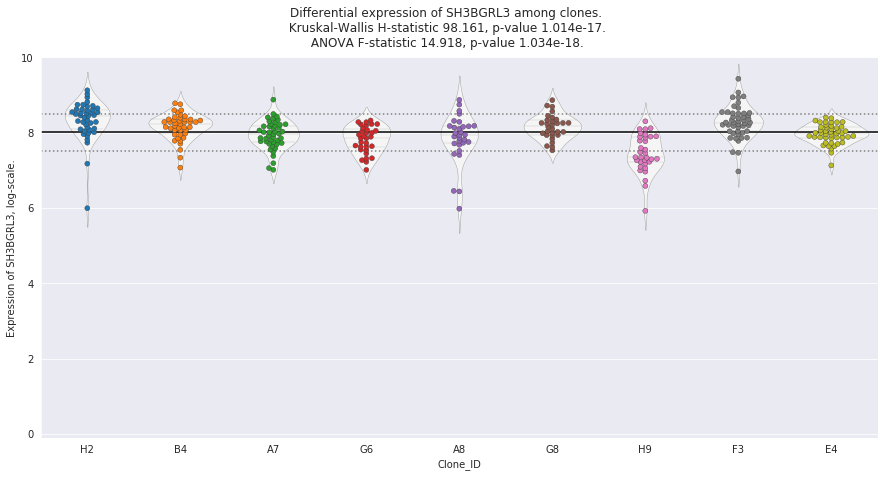

In [45]:
swarm_gene(genes_sig12[5])

In [46]:
gene_labels.describe()

count                     238
unique                      8
top       Ribosomal Processes
freq                       82
dtype: object

In [48]:
genes_sig6ON = [gene for gene in genes_sig6 if gene in genes_ON]
print(', '.join(genes_sig6ON))

MTATP6P1, SH3BGRL3, CD52, IFI6, CD2, SRGN, MALAT1, CFL1, CD3G, TRAC, GZMB, B2M, IL32, PFN1, CCL5!1, CCL4, RPS19!0, FTL, NKG7, AC092580.4, ID2, TMSB10, STK17B, CST7, APOBEC3C, TMSB4XP8, CD74, HNRNPH1, HLA-B!1, LTB!1, ACTB, MT-RNR1, MT-RNR2, MT-CO2, MT-ATP6, MT-ND4L, MT-ND4, MT-ND5, MT-TE, MT-CYB, AC010970.2


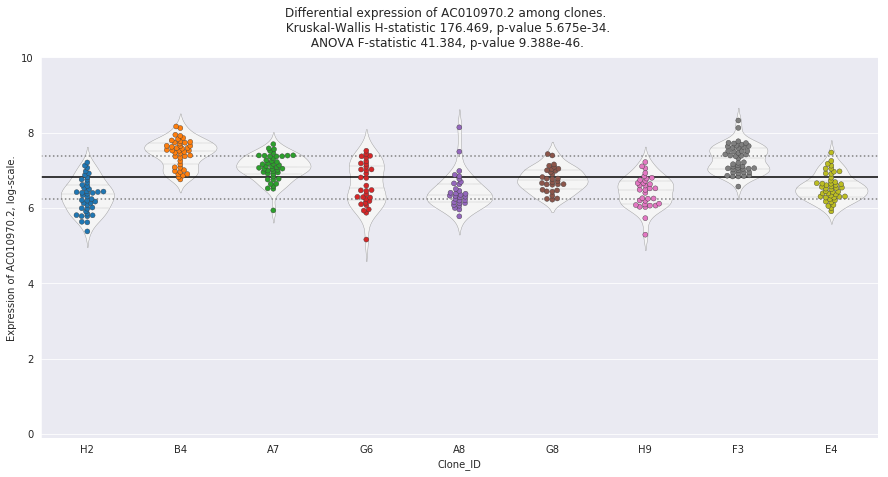

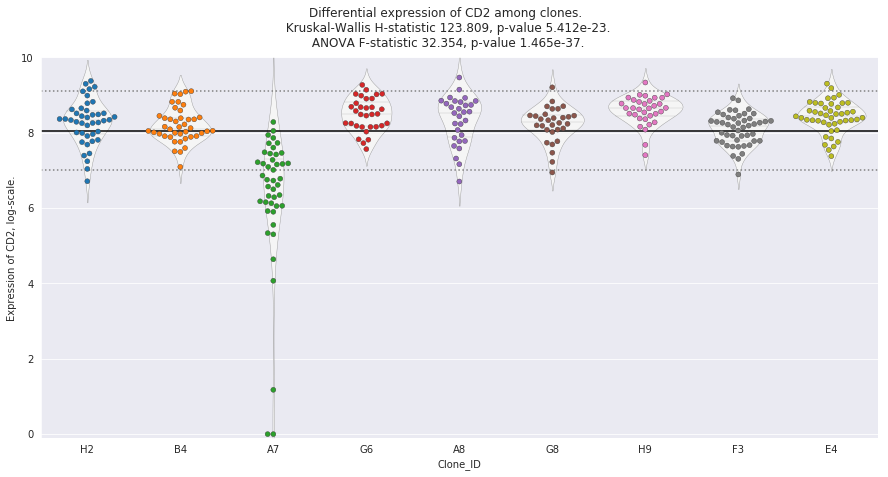

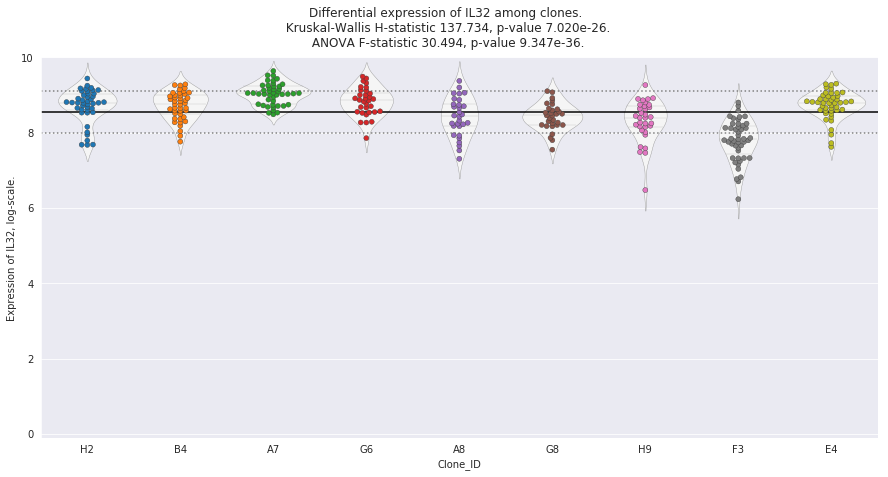

In [49]:
for gene in ANOVA_df.loc[genes_sig6ON].sort_values('p').index[:3]:
    swarm_gene(gene)

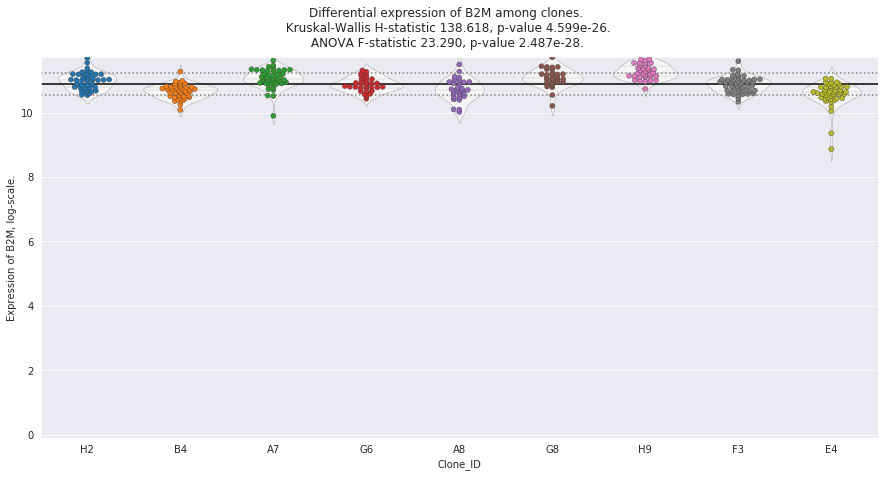

In [50]:
swarm_gene('B2M')

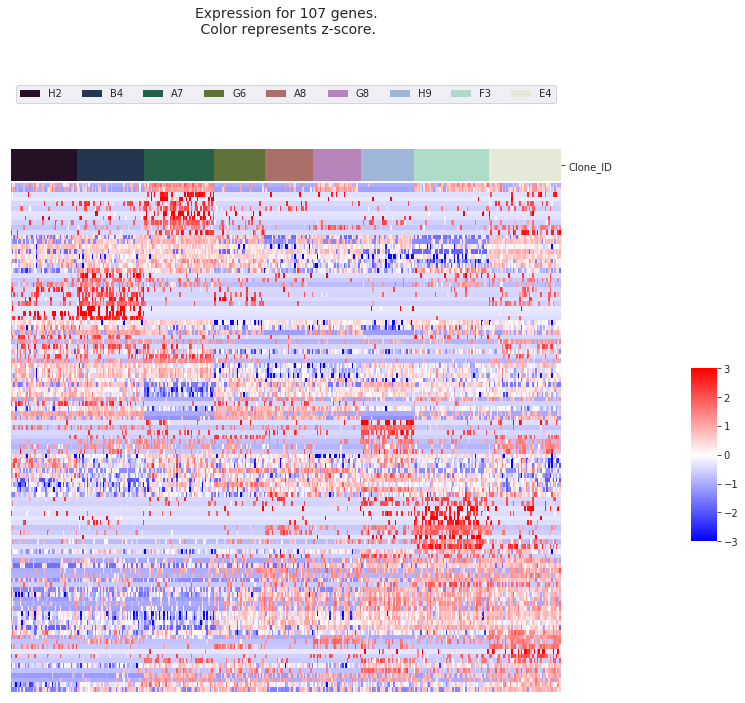

In [51]:
vis_genebars(X, meta_df, genes_sig12, 'Clone_ID', classlist = clones, genelabels=False)

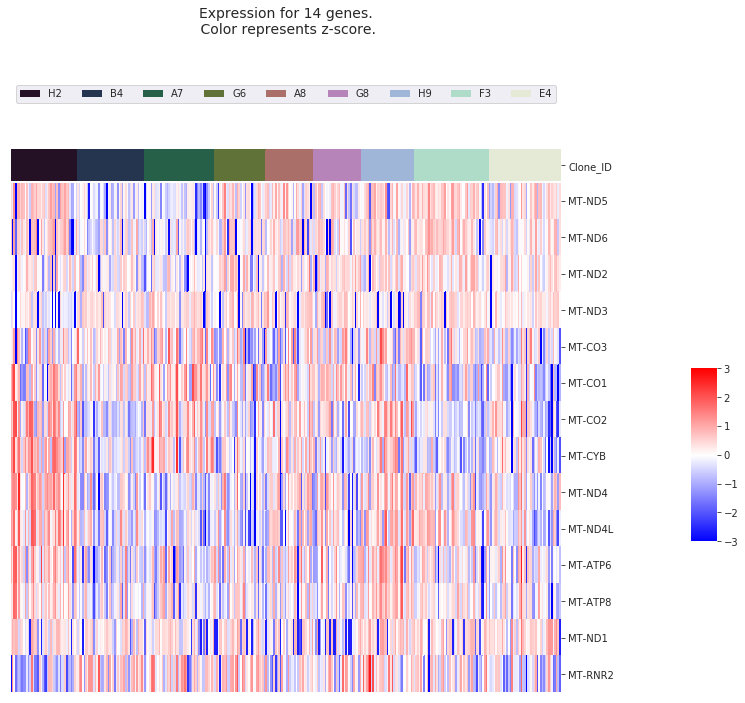

In [52]:
vis_genebars(X, meta_df, gene_paths['MT-genes'], 'Clone_ID', classlist = clones, genelabels=True)

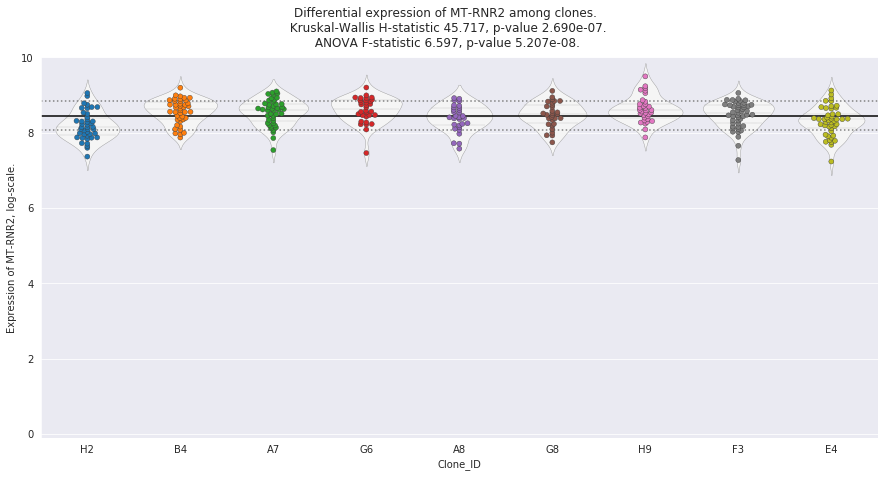

In [53]:
swarm_gene('MT-RNR2')

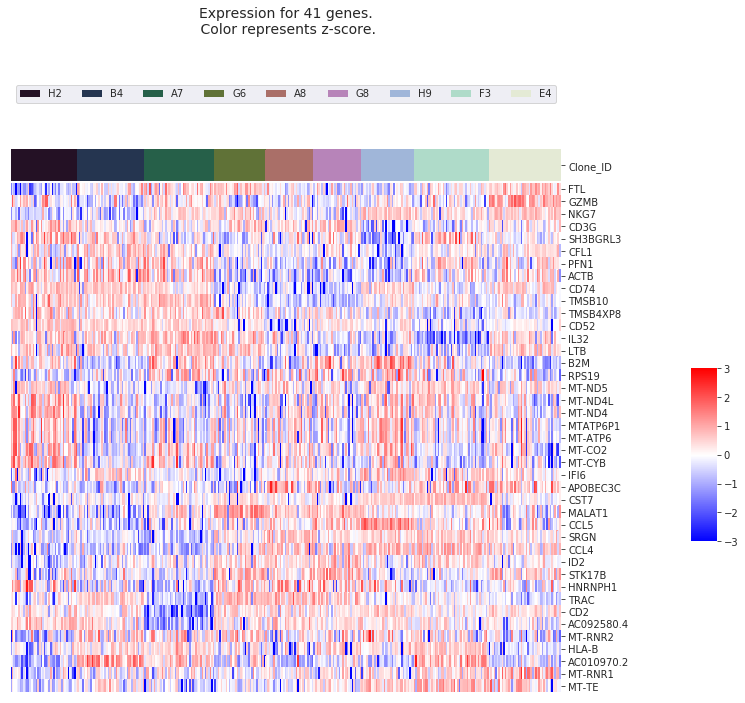

In [54]:
vis_genebars(X, meta_df, genes_sig6ON, 'Clone_ID', classlist = clones, genelabels=True)

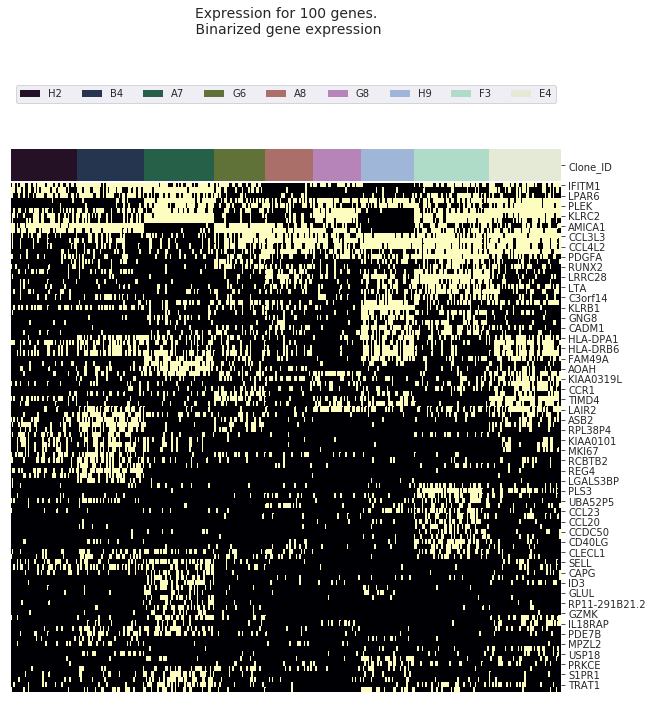

In [55]:
vis_genebars(X, meta_df, genes_onoff, 'Clone_ID', classlist = clones, genelabels=True, style='binarize')

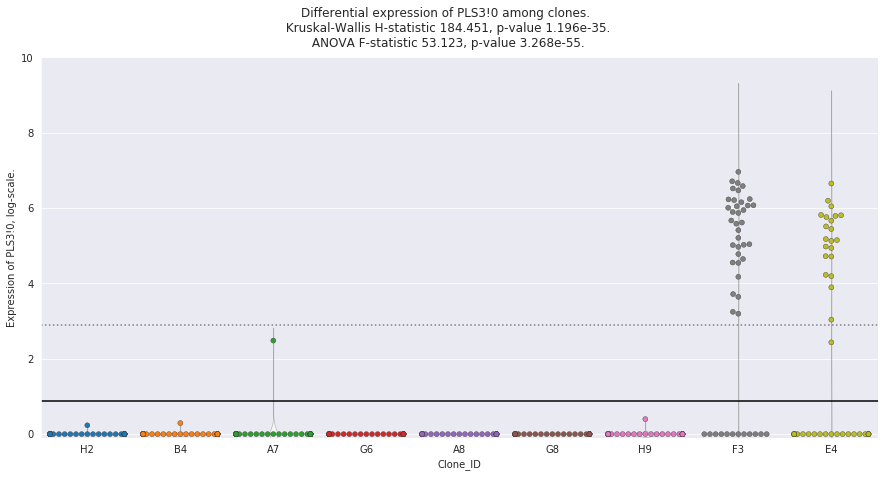

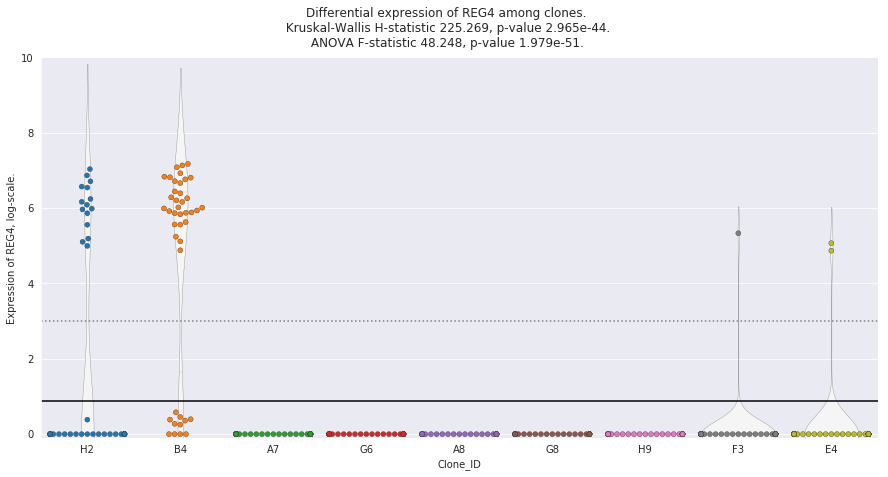

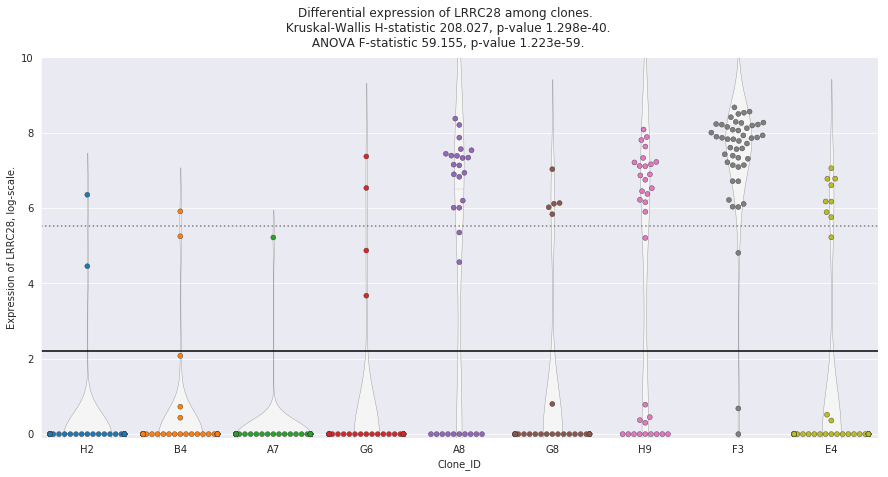

In [56]:
for gene in genes_onoff[:3]:
    swarm_gene(gene)

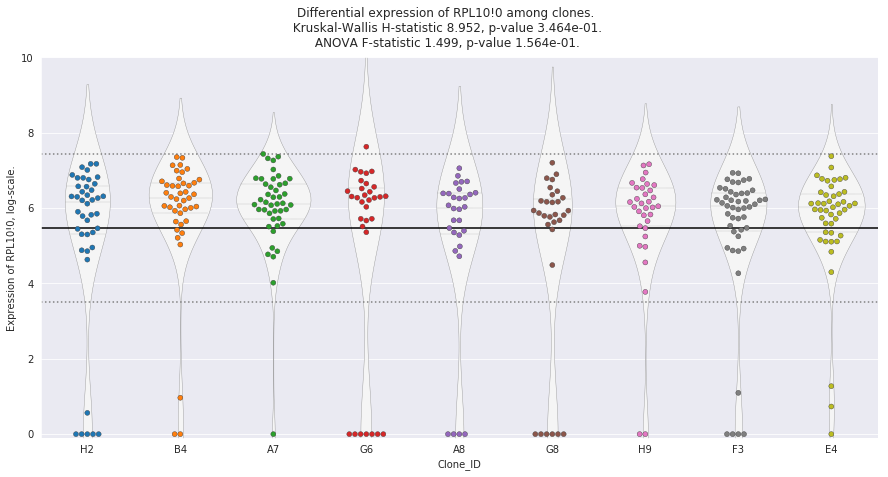

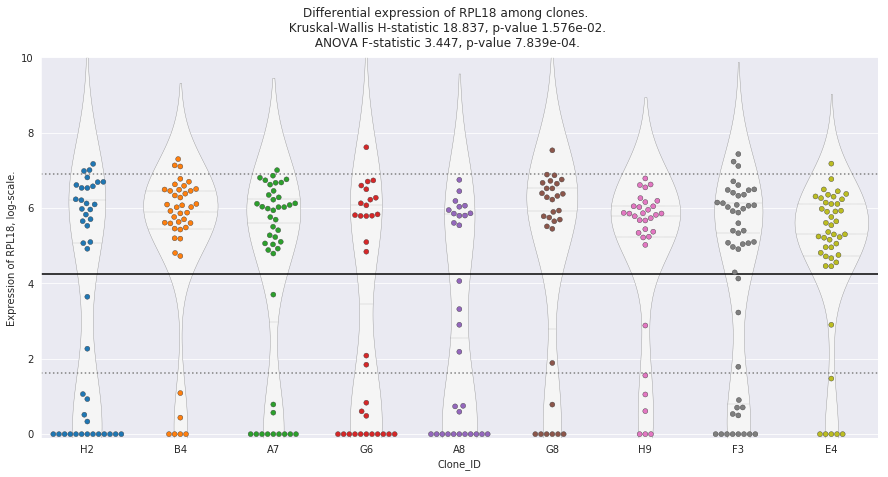

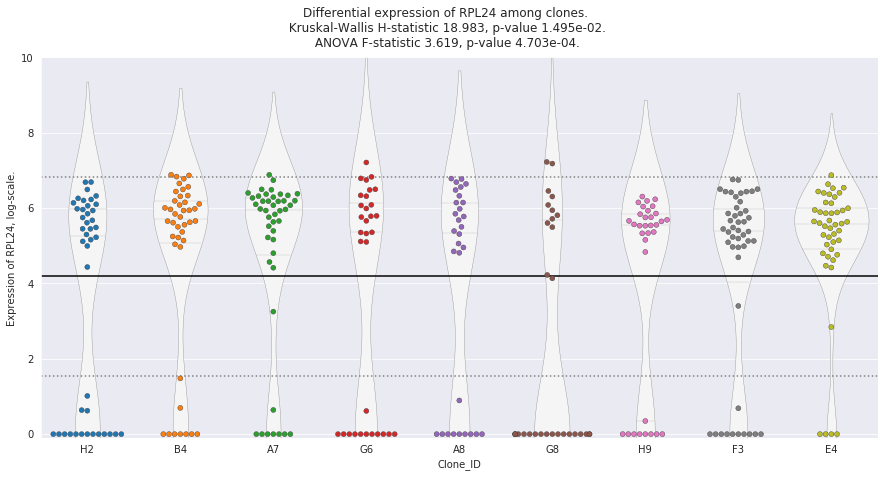

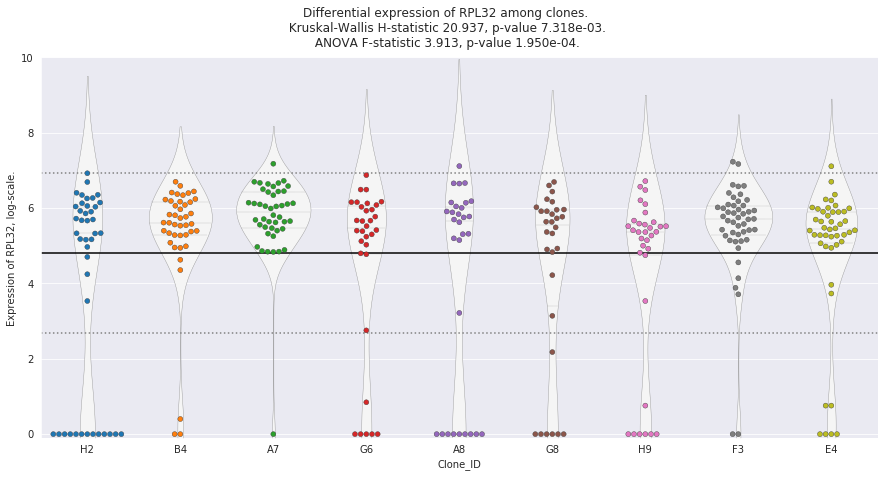

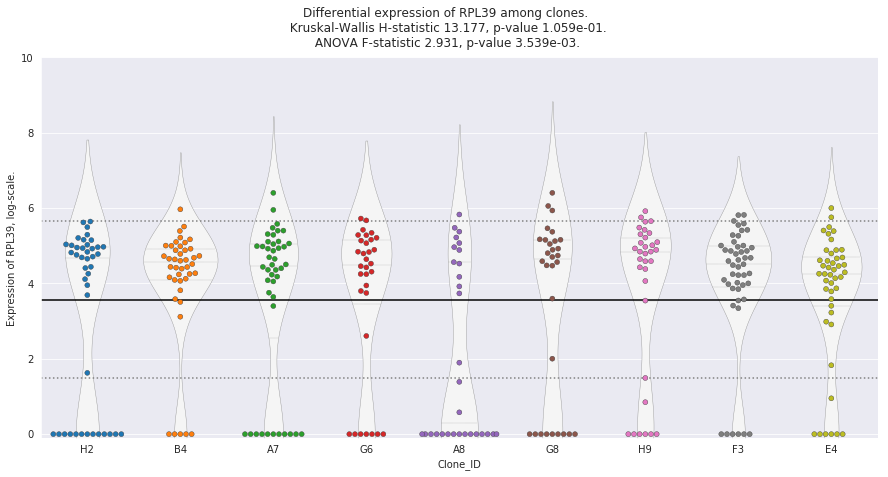

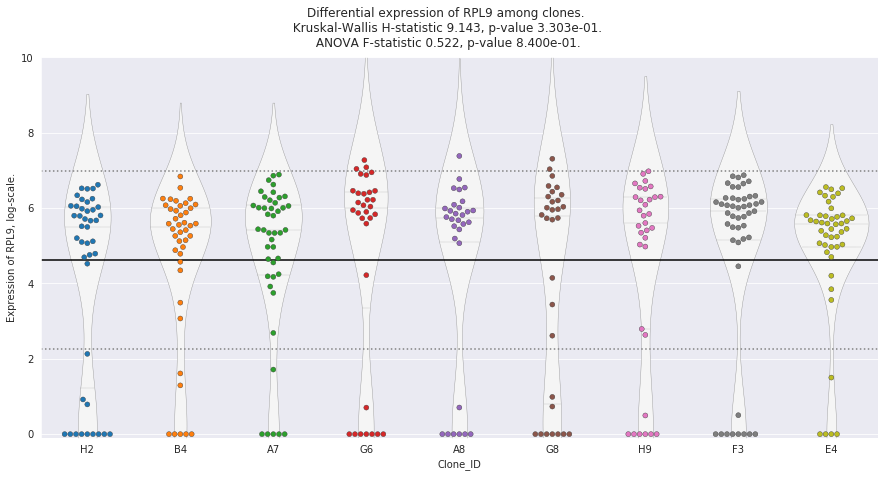

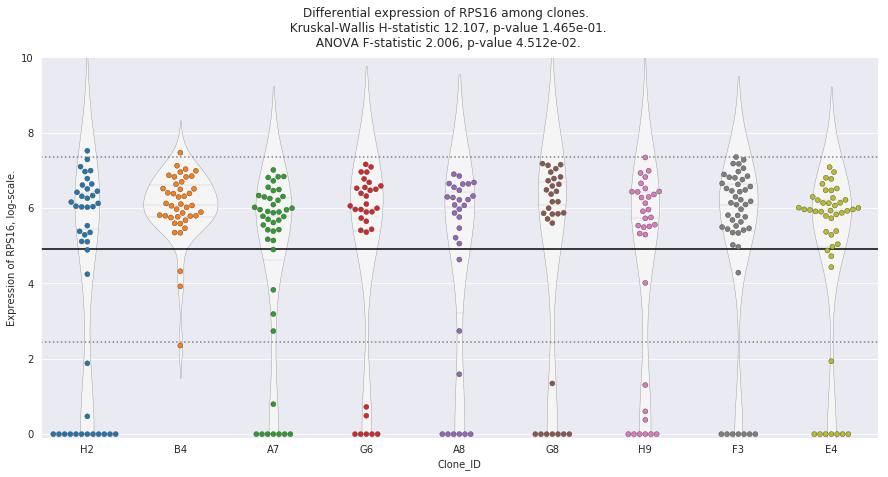

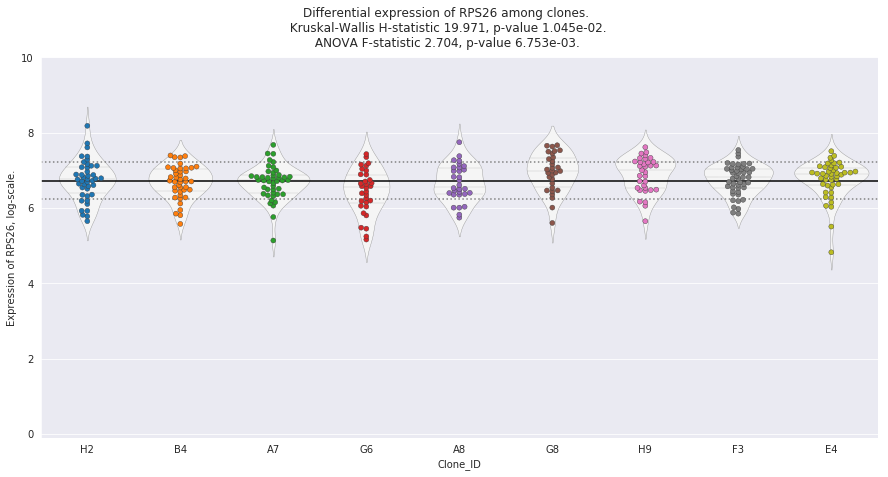

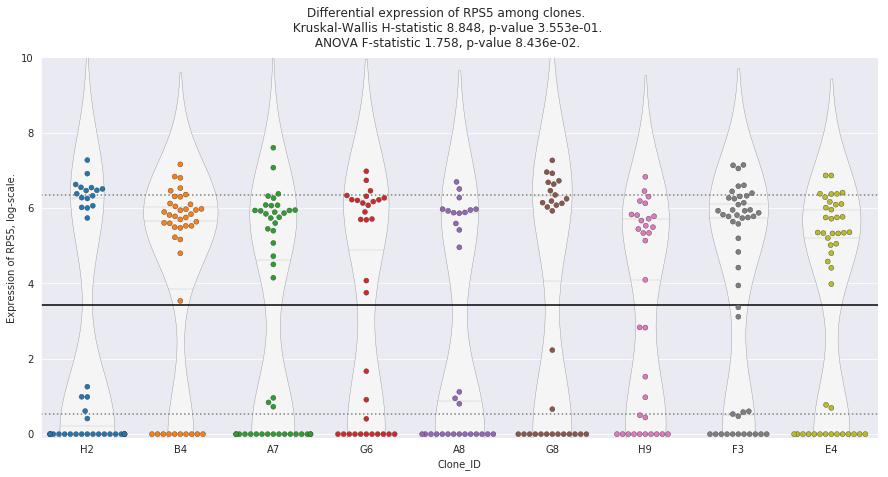

In [57]:
for gene in gene_paths['Ribosomal Processes'][::10]:
    swarm_gene(gene)

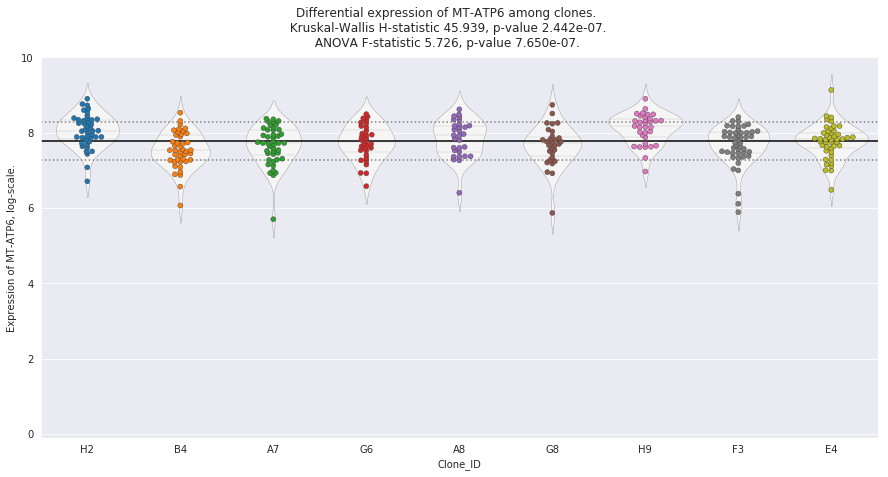

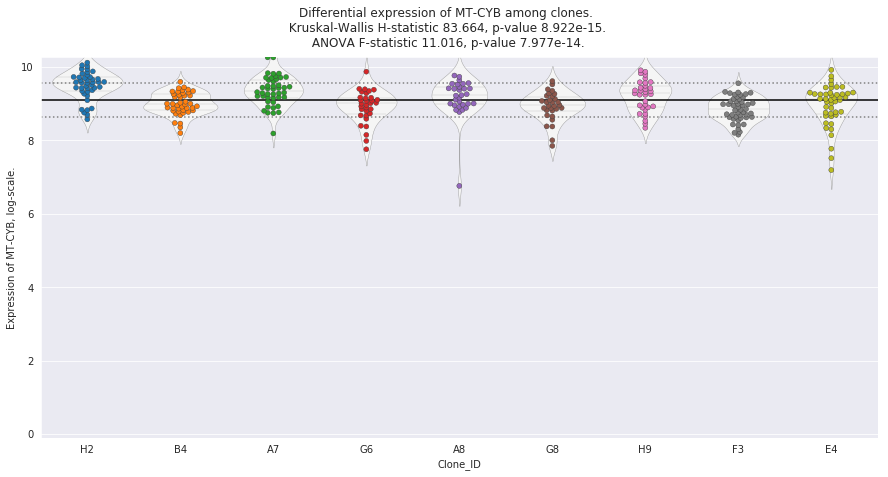

KeyboardInterrupt: 

In [58]:
for gene in gene_paths['MT-genes'][::5]:
    swarm_gene(gene)

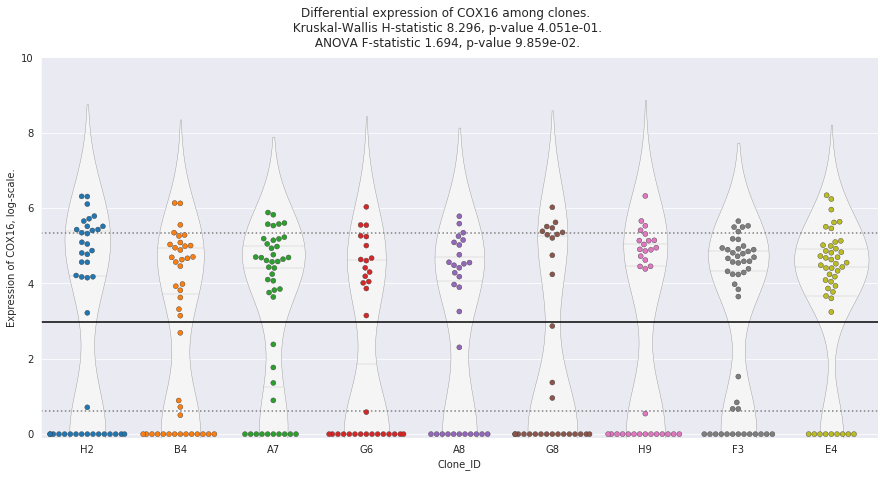

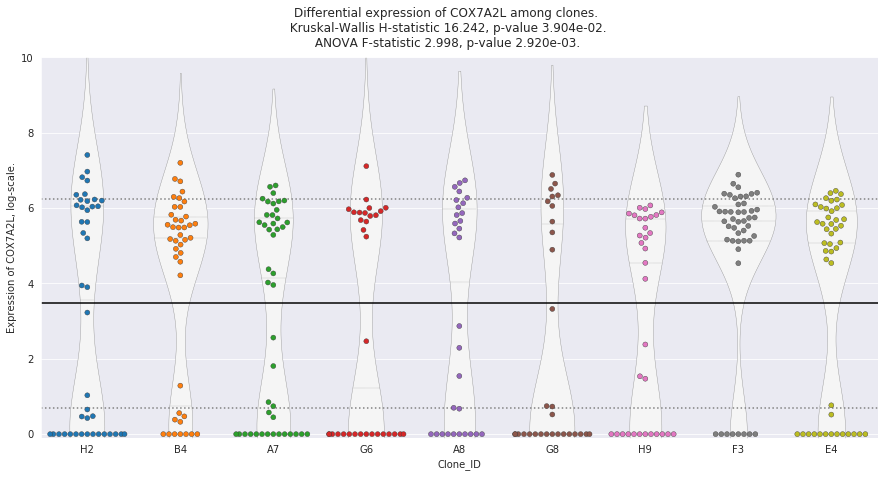

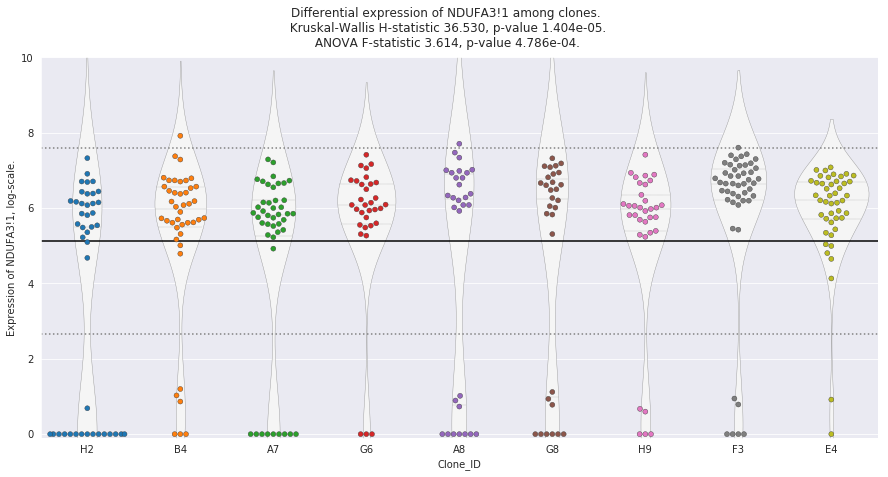

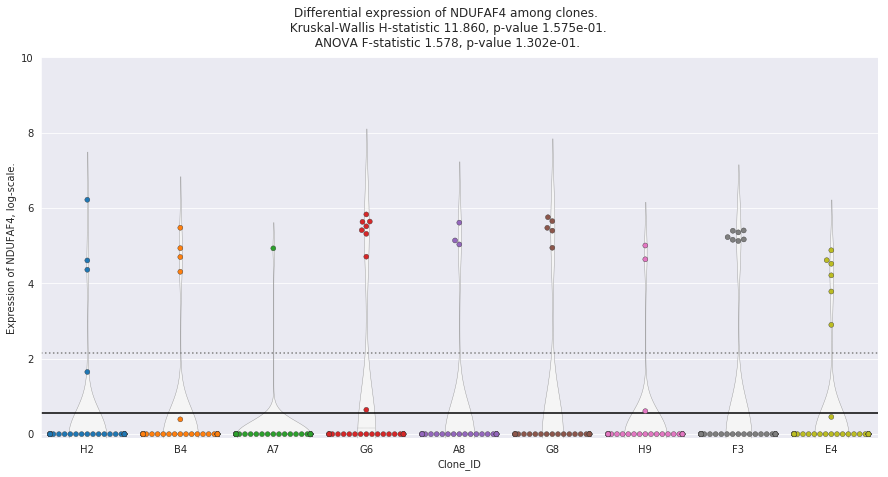

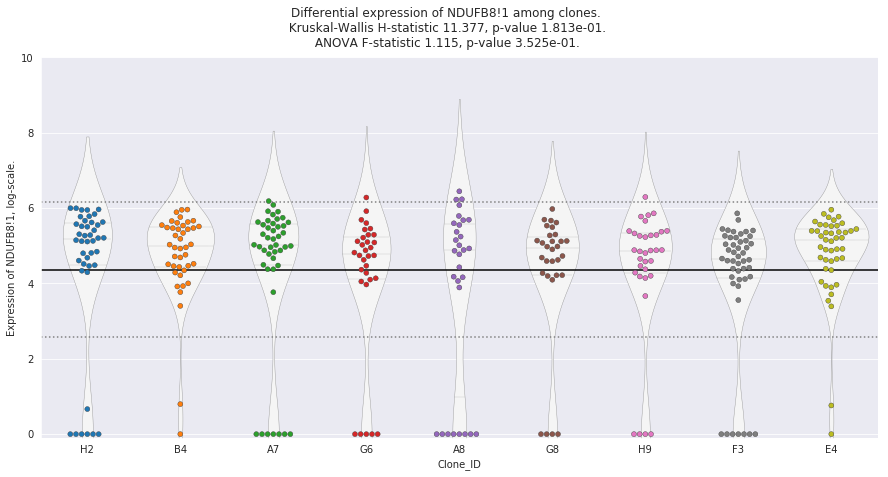

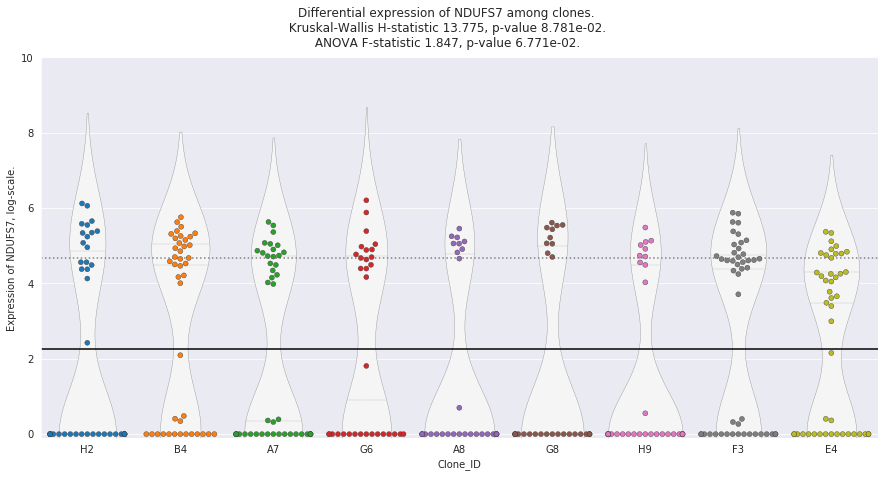

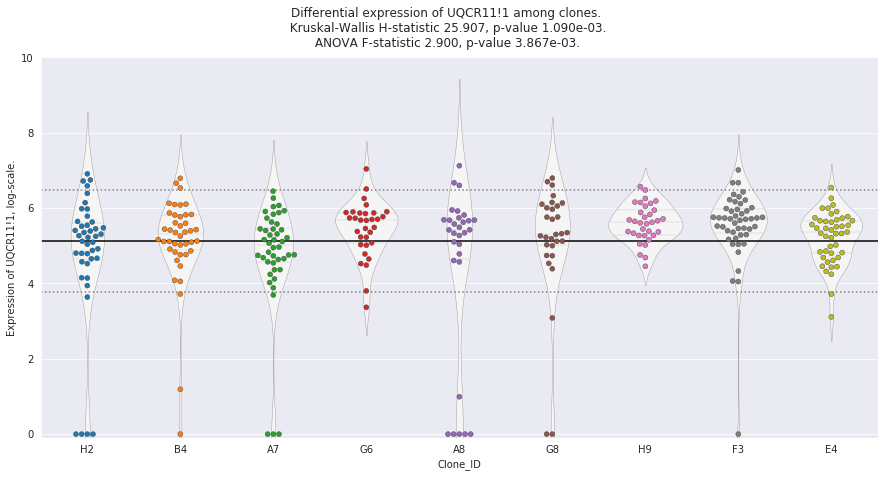

In [59]:
for gene in gene_paths['Mitochondrial Respiration'][::10]:
    swarm_gene(gene)

# Clonal pathway analysis

In [60]:
for pathway in pathways:
    print('Pathway {} contains the following genes:  {}.'.format(pathway, ', '.join(gene_paths[pathway])))
    print('---------------------------------------')

Pathway CD3/TCR Signaling contains the following genes:  CD247, CD3D, CD3E, CD3G, CD8A, CD8B, FYN, LAT, LCK, LCP2, MAPK1, MAPK14, NCK1, PRKCQ, ZAP70.
---------------------------------------
Pathway Cytotoxicity contains the following genes:  CD63, CTSC, CTSD, CTSL, GNLY, GZMA, GZMB, GZMH, LAMP1, LAMP2, M6PR, PRF1, RAB27A, SH2D1A, STXBP2, STXBP3, UNC13D.
---------------------------------------
Pathway Exhaustion contains the following genes:  CD244, CD28, CTLA4, HAVCR2, LAG3, MAF, PDCD1, PPP2CA, PTPN11, PTPN6!0, TIGIT, TIMD4, TNFRSF9.
---------------------------------------
Pathway IL-2R Signaling contains the following genes:  IL2RA, IL2RB, IL2RG, JAK3, PIK3CA, STAT3, STAT5B.
---------------------------------------
Pathway Ribosomal Processes contains the following genes:  RPL10!0, RPL10A, RPL11, RPL12, RPL13, RPL13A, RPL13AP5, RPL14, RPL15, RPL17, RPL18, RPL18A, RPL19, RPL21, RPL22, RPL22L1, RPL23, RPL23A, RPL23AP7, RPL23AP82!1, RPL24, RPL26, RPL26L1, RPL27, RPL27A, RPL28, RPL29, RPL3

In [61]:
def pathstrip(gf, mf, pathway):
    path_genes = gene_paths[pathway]
    clone_means = gf[path_genes].groupby(mf).mean()
    all_std = gf[path_genes].std()
    all_means = gf[path_genes].mean()
    clone_devs = (clone_means - all_means) / all_std
    
    plot_df = clone_devs.transpose()
    plot_df['gene'] = plot_df.index
    plot_df = plot_df.sort_values('gene')
    
    fig, ax = plt.subplots(1, len(clones), figsize=(len(clones)*2 + 1, 0.25 * len(path_genes)))
    j = 0
    for clone in clones:
        ax[j].scatter(plot_df[clone],plot_df['gene'], c=plot_df[clone], cmap='seismic') 
        ax[j].set_xticks([-1,0,1])
        ax[j].set_xticklabels(['-$\sigma$','mean','+$\sigma$'], {'verticalalignment': 'baseline'})
        ax[j].axvline(0, color='white', zorder=-2)
        ax[j].grid(visible=False)
        if j > 0:
            ax[j].get_yaxis().set_visible(False)
        ax[j].set_title('Clone {}'.format(clone))
        j += 1
    
    plt.show()
    return None

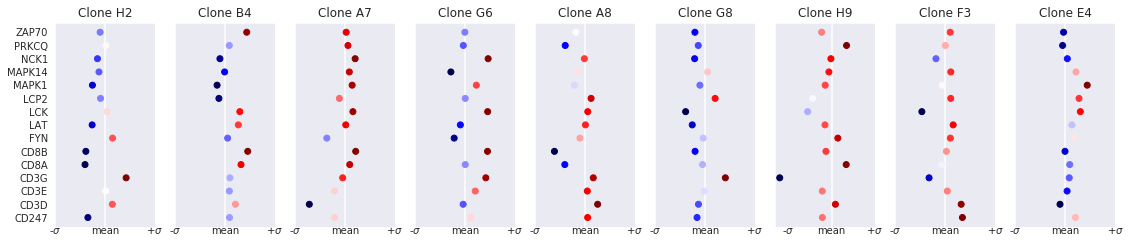

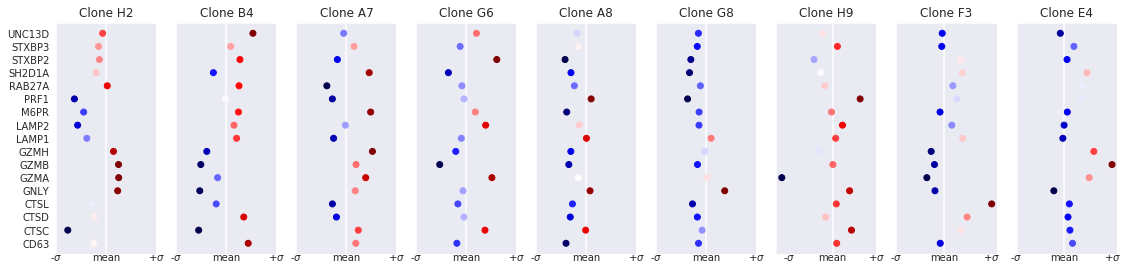

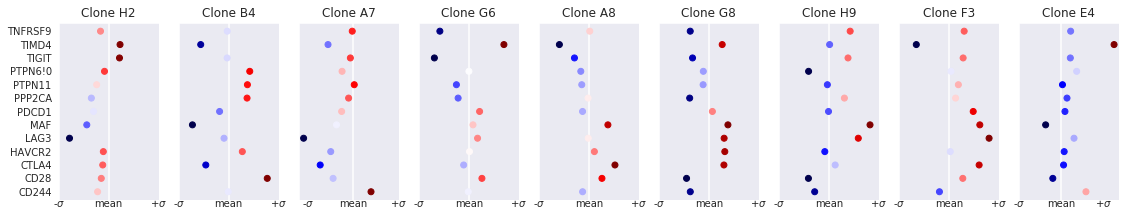

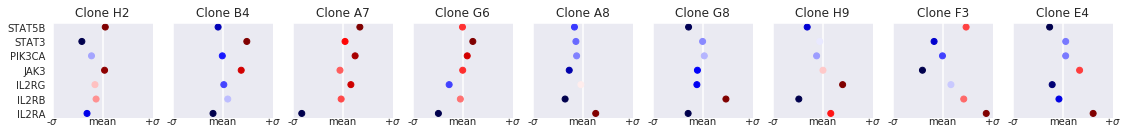

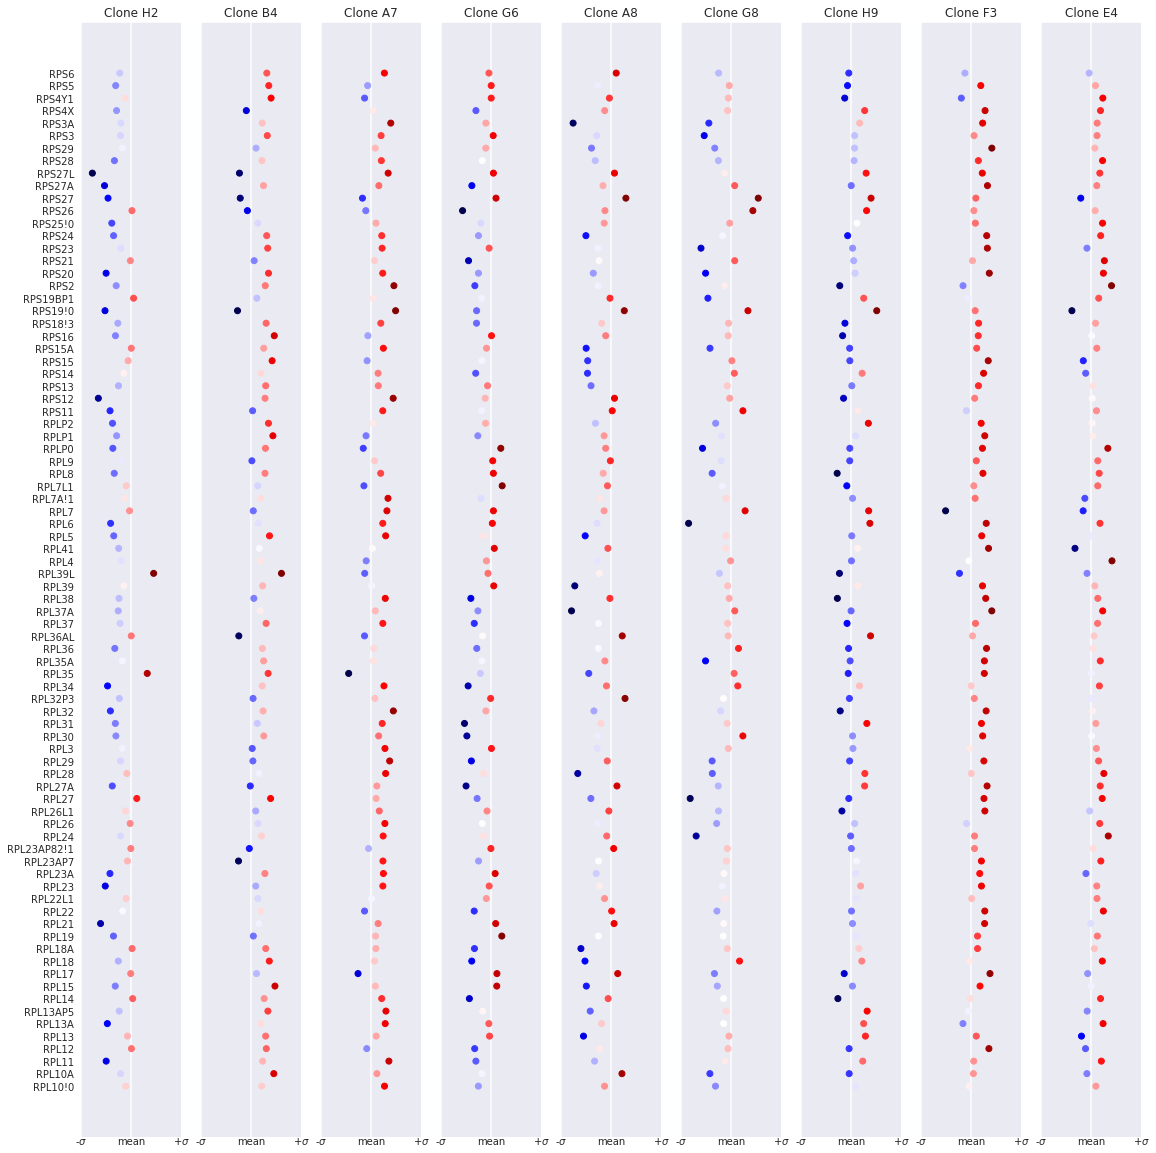

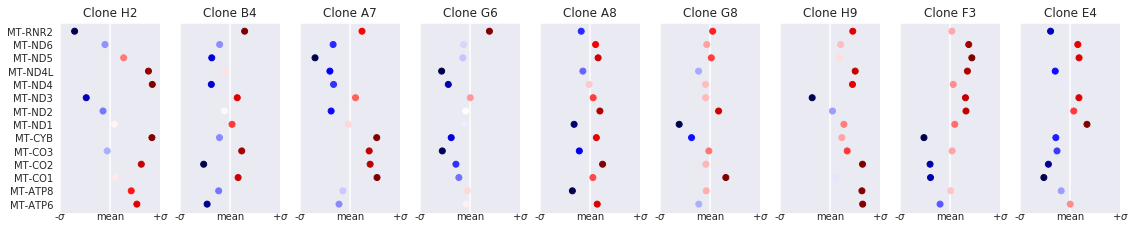

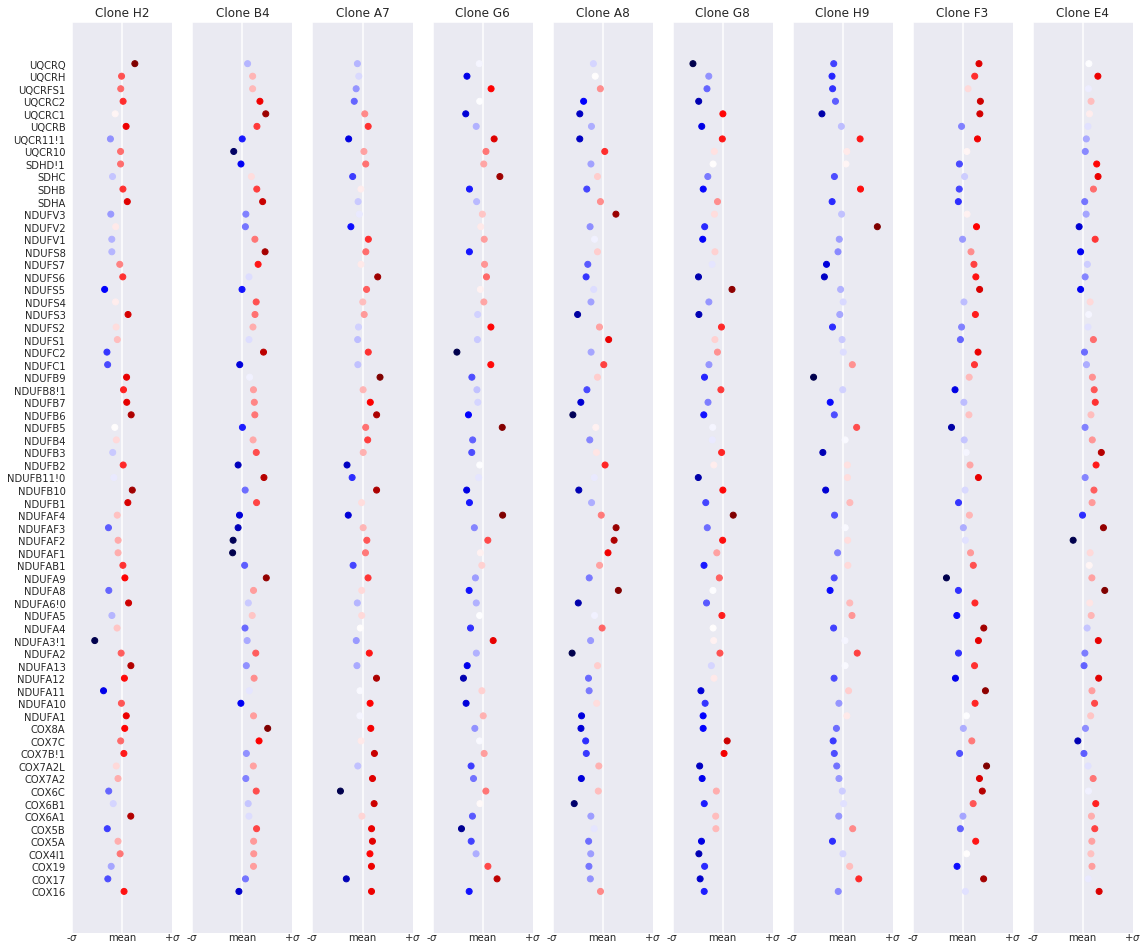

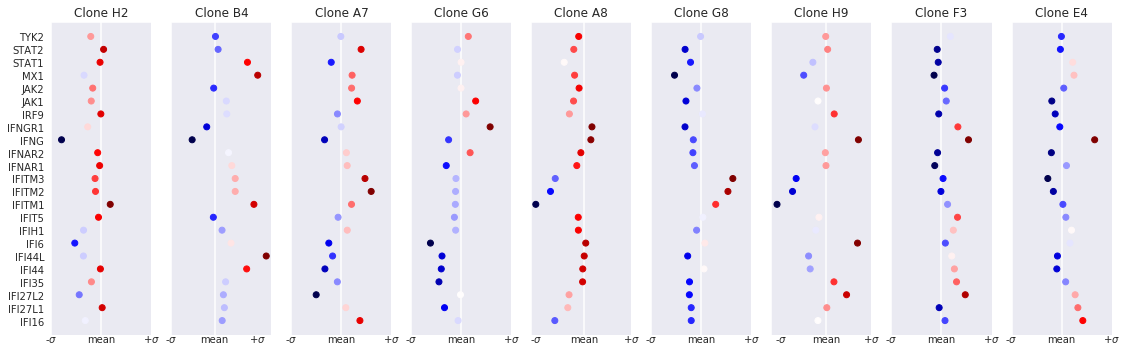

In [62]:
for pathway in pathways:
    pathstrip(X,y,pathway)